# Admission Analysis for Ukrainian Universities (2020–2024)

## **Project Overview**
The goal of the project is to investigate trends in higher education in Ukraine, to determine the impact February 24 had on Ukrainian education.
Issues of distribution by regions, specialties, and fields of knowledge have been studied.

---

## **Dataset Details**
The dataset contains:
- **Competitive Offers (2020–2024):** Includes specialties, regions, industries, number of applications, universities, and additional details.
- **Entrant Data (2020–2022):** Provides statistics on applications per competitive offer, average admission priorities, scores, state order volume, budget, and contract data.

---

## **Questions**
1. What are the trends in admission priorities across regions from 2020 to 2022?
2. How do average scores correlate with priorities in different regions?  
3. Which universities ranked in the top 10 for highest admission exam scores from 2020 to 2022?  
4. What are the top 10 specialties with the highest scores from 2020 to 2022?  
5. How are enrollment applications distributed across regions from 2020 to 2024?  
6. How is application distribution changing across education levels from 2020 to 2024?  
7. How are budget and contract entrants distributed from 2020 to 2022?  
8. What is the distribution of applications across universities from 2020 to 2024?  
9. How are students distributed by admission scores from 2020 to 2022?  
10. What is the distribution of applications across different industries from 2020 to 2024?  
11. What are the top specialties by application volume from 2020 to 2024?  
12. How did application distribution change geographically before and after February 2022?  
13. Which regions exceed or fall below the national average in applications per population?  
14. How has license capacity utilization varied across regions from 2020 to 2022?  
15. What is the correlation between license capacity and the level of competition?  
16. How do license capacity and average entrance scores correlate?
17. Is the thesis that the east of Ukraine is industrial true?
---


#### Installing packages

In [1]:
!pip install pandas mat plotly seaborn networkx geopandas lxml squarify

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 4.7 MB/s eta 0:00:00m eta 0:00:010:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 4.8 MB/s eta 0:00:00 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 4.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 KB 6.1 MB/s eta 0:00:00 MB/s eta 0:00:01
  Using cached lxml-5.3.0-cp310-cp310-manylinux_2_28_x86_64.whl (5.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 KB 4.8 MB/s eta 0:00:000:00:01m eta 0:00:01
  Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 3.9 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 5.7 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

#### Import required libraries

In [2]:
import json
import textwrap

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import offset_copy
import squarify

#### Loading data into dataframes

In [3]:
# Data about statistic of tender offers
statistics = "./data/statistics.csv"
df = pd.read_csv(statistics)

# Data by the name of the region and its code
regions = "./data/regions.json"
with open(regions, 'r', encoding='utf-8') as file:
    regions_data = json.load(file)
regions_df = pd.DataFrame(regions_data)
regions_df = regions_df.rename(columns={"code": "region_code", "name": "region_name"})

# Data about its universities: their names and codes
universities = "./data/universities.json"
with open(universities, 'r', encoding='utf-8') as file:
    universities_data = json.load(file)
universities_df = pd.DataFrame(universities_data)
universities_df = universities_df.rename(columns={"code": "university_code", "name": "university_name"})
universities_df = universities_df[["university_code", "university_name"]]
universities_df['university_code'] = universities_df['university_code'].astype('int64')

# Data for displaying the map of Ukraine
ukraine_map_json = "./data/Ukraine-regions.json"
ukraine_map = gpd.read_file(ukraine_map_json)
with open('data/latin_to_cyrillic_region_names.json', 'r', encoding='utf-8') as json_file:
    latin_to_cyrillic_region_names = json.load(json_file)
ukraine_map['cyrillic_name'] = ukraine_map["NAME_1"].map(latin_to_cyrillic_region_names)
with open('data/region_to_part_of_ukraine.json', 'r', encoding='utf-8') as json_file:
    region_to_part_of_ukraine = json.load(json_file)
ukraine_map['part'] = ukraine_map["cyrillic_name"].map(region_to_part_of_ukraine)

# Data about tender offers
tender_offers = "./data/tender_offers.csv"
tender_offers = pd.read_csv(tender_offers)
tender_offers = tender_offers.merge(regions_df, on="region_code", how="left")
tender_offers = tender_offers.merge(universities_df, on="university_code", how="left")

# Data about population of Ukraine
url = 'https://uk.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%BE%D0%B1%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D0%B9_%D0%A3%D0%BA%D1%80%D0%B0%D1%97%D0%BD%D0%B8_%D0%B7%D0%B0_%D1%87%D0%B8%D1%81%D0%B5%D0%BB%D1%8C%D0%BD%D1%96%D1%81%D1%82%D1%8E_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%BD%D1%8F'
tables = pd.read_html(url)
population_by_region = tables[0]
population_by_region = population_by_region[['Область', 'сукупне населення']]
population_by_region = population_by_region.rename(columns={'Область': 'region', 'сукупне населення': 'population'})
population_by_region['population'] = population_by_region['population'].replace({'\D': ''}, regex=True).astype(int)
population_by_region['region'] = population_by_region['region'].replace({'м.Київ': 'Київ',})
population_by_region = population_by_region[
    (population_by_region['region'] != 'Україна') & 
    (population_by_region['region'] != 'Автономна Республіка Крим') & 
    (population_by_region['region'] != 'м.Севастополь')
]

## Tender offres basic info

In [4]:
tender_offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598407 entries, 0 to 598406
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   education_form       598407 non-null  object 
 1   education_level      598407 non-null  object 
 2   education_entry      598407 non-null  object 
 3   area                 598407 non-null  object 
 4   university_code      598407 non-null  int64  
 5   region_code          598407 non-null  object 
 6   speciality_code      598407 non-null  int64  
 7   speciality_name      576794 non-null  object 
 8   year                 598407 non-null  int64  
 9   offer_type           598407 non-null  object 
 10  education_program    598407 non-null  object 
 11  license_number       489264 non-null  float64
 12  contract_number      405843 non-null  float64
 13  min_state_order      48550 non-null   float64
 14  max_state_order      48550 non-null   float64
 15  url              

In [5]:
tender_offers.head(10)

education_form education_level  \
0      EducationForm.INTRAMURAL        Бакалавр   
1      EducationForm.INTRAMURAL        Бакалавр   
2      EducationForm.INTRAMURAL        Бакалавр   
3      EducationForm.INTRAMURAL        Бакалавр   
4      EducationForm.INTRAMURAL         Магістр   
5      EducationForm.INTRAMURAL         Магістр   
6  EducationForm.CORRESPONDENCE        Бакалавр   
7  EducationForm.CORRESPONDENCE        Бакалавр   
8  EducationForm.CORRESPONDENCE        Бакалавр   
9  EducationForm.CORRESPONDENCE         Магістр   

                           education_entry                  area  \
0  на основі Повна загальна середня освіта  Міжнародні відносини   
1  на основі Повна загальна середня освіта  Міжнародні відносини   
2  на основі Повна загальна середня освіта  Міжнародні відносини   
3            на основі Молодший спеціаліст  Міжнародні відносини   
4                       на основі Бакалавр  Міжнародні відносини   
5                       на основі Бакалавр  Міжнародні відносини   
6  на основі Повна загальна середня освіта  Міжнародні відносини   
7            на основі Молодший спеціаліст  Міжнародні відносини   
8                       на основі Бакалавр  Міжнародні відносини   
9                       на основі Бакалавр  Міжнародні відносини   

   university_code region_code  speciality_code   speciality_name  year  \
0              364         r27              293  Міжнародне право  2024   
1              364         r27               81             Право  2024   
2              364         r27               81             Право  2024   
3              364         r27               81             Право  2024   
4              364         r27              293  Міжнародне право  2024   
5              364         r27               81             Право  2024   
6              364         r27               81             Право  2024   
7              364         r27               81             Право  2024   
8              364         r27               81             Право  2024   
9              364         r27               81             Право  2024   

   offer_type                         education_program  license_number  \
0  Небюджетна                          Міжнародне право            75.0   
1  Небюджетна  Право: спеціальна адвокатська підготовка            15.0   
2  Небюджетна                                     Право           115.0   
3  Небюджетна                                     Право            20.0   
4  Небюджетна                          Міжнародне право            30.0   
5  Небюджетна                                     Право            60.0   
6  Небюджетна                                     Право            30.0   
7  Небюджетна                                     Право            20.0   
8  Небюджетна                                     Право           100.0   
9  Небюджетна                                     Право            90.0   

   contract_number  min_state_order  max_state_order  \
0             75.0              NaN              NaN   
1             15.0              NaN              NaN   
2            115.0              NaN              NaN   
3             20.0              NaN              NaN   
4             30.0              NaN              NaN   
5             60.0              NaN              NaN   
6             30.0              NaN              NaN   
7             20.0              NaN              NaN   
8            100.0              NaN              NaN   
9             90.0              NaN              NaN   

                                              url  applications_number  \
0  https://vstup.osvita.ua/y2024/r27/364/1294127/                   44   
1  https://vstup.osvita.ua/y2024/r27/364/1335604/                   23   
2  https://vstup.osvita.ua/y2024/r27/364/1338101/                  177   
3  https://vstup.osvita.ua/y2024/r27/364/1338146/                   10   
4  https://vstup.osvita.ua/y2024/r27/364/1294128/                  

## Statistics on applications for each tender offer

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162524 entries, 0 to 162523
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   education_form              162524 non-null  object 
 1   education_level             162524 non-null  object 
 2   education_entry             162524 non-null  object 
 3   area                        162524 non-null  object 
 4   university_code             162524 non-null  int64  
 5   region_code                 162524 non-null  object 
 6   speciality_code             162524 non-null  int64  
 7   speciality_name             157148 non-null  object 
 8   year                        162524 non-null  int64  
 9   offer_type                  162524 non-null  object 
 10  education_program           162524 non-null  object 
 11  avg_score_budget            54705 non-null   float64
 12  avg_score_contract          102485 non-null  float64
 13  avg_zno_score_

In [7]:
df.head(10)

education_form education_level  \
0      EducationForm.INTRAMURAL        Бакалавр   
1      EducationForm.INTRAMURAL        Бакалавр   
2      EducationForm.INTRAMURAL        Бакалавр   
3      EducationForm.INTRAMURAL        Бакалавр   
4      EducationForm.INTRAMURAL        Бакалавр   
5      EducationForm.INTRAMURAL        Бакалавр   
6      EducationForm.INTRAMURAL        Бакалавр   
7      EducationForm.INTRAMURAL         Магістр   
8      EducationForm.INTRAMURAL         Магістр   
9  EducationForm.CORRESPONDENCE        Бакалавр   

                           education_entry                  area  \
0  на основі Повна загальна середня освіта  Міжнародні відносини   
1  на основі Повна загальна середня освіта  Міжнародні відносини   
2  на основі Повна загальна середня освіта  Міжнародні відносини   
3  на основі Повна загальна середня освіта  Міжнародні відносини   
4  на основі Повна загальна середня освіта  Міжнародні відносини   
5            на основі Молодший спеціаліст  Міжнародні відносини   
6            на основі Молодший спеціаліст  Міжнародні відносини   
7                       на основі Бакалавр  Міжнародні відносини   
8                       на основі Бакалавр  Міжнародні відносини   
9  на основі Повна загальна середня освіта  Міжнародні відносини   

   university_code region_code  speciality_code   speciality_name  year  \
0              364         r27              293  Міжнародне право  2022   
1              364         r27              293  Міжнародне право  2022   
2              364         r27               81             Право  2022   
3              364         r27               81             Право  2022   
4              364         r27               81             Право  2022   
5              364         r27               81             Право  2022   
6              364         r27               81             Право  2022   
7              364         r27              293  Міжнародне право  2022   
8              364         r27               81             Право  2022   
9              364         r27               81             Право  2022   

   offer_type  ... min_zno_score_budget  min_rating_score_budget  \
0  Небюджетна  ...                  NaN                      NaN   
1  Небюджетна  ...                  NaN                      NaN   
2  Небюджетна  ...                  NaN                      NaN   
3  Небюджетна  ...                  NaN                      NaN   
4  Небюджетна  ...                  NaN                      NaN   
5  Небюджетна  ...                  NaN                      NaN   
6  Небюджетна  ...                  NaN                      NaN   
7  Небюджетна  ...                  NaN                      NaN   
8  Небюджетна  ...                  NaN                      NaN   
9  Небюджетна  ...                  NaN                      NaN   

   total_enrolled_budget  total_enrolled_contract  max_budget_capacity  \
0                    NaN                      4.0                  NaN   
1                    NaN                      2.0                  NaN   
2                    NaN                      6.0                  NaN   
3                    NaN                      7.0                  NaN   
4                    NaN                      1.0                  NaN   
5                    NaN                      4.0                  NaN   
6                    NaN                      1.0                  NaN   
7                    NaN                      9.0                  NaN   
8                    NaN                     23.0                  NaN   
9                    NaN                      4.0                  NaN   

   total_apps  avg_priority  license_capacity  unused_license_capacity  \
0        48.0           NaN              50.0                     46.0   
1         3.0           NaN              25.0                     23.0   
2        38.0           NaN              30.0                     24.0   
3       162.0       

#### Definition of bachelors

In [8]:
secondary_education = 'на основі Повна загальна середня освіта'

bachelors = df[(df["education_level"]=='Бакалавр') & (df['education_entry']==secondary_education)].copy()
bachelors = bachelors[
    bachelors["total_apps"].notna() & 
    bachelors["avg_score_all"].notna() & 
    (bachelors["total_enrolled_contract"].notna() | bachelors["total_enrolled_budget"].notna())
]
bachelors['entered_number'] = (
    bachelors['total_enrolled_contract'].fillna(0) + 
    bachelors['total_enrolled_budget'].fillna(0)
)
bachelors = bachelors.merge(regions_df, on="region_code", how="left")
bachelors = bachelors.merge(universities_df, on="university_code", how="left")

#### Function for correct placement of region names

In [9]:
def adjust_coordinates(x: float, y: float, row: pd.Series) -> tuple[float, float]:
    if row['cyrillic_name'] == "Київська область":
        y -= 0.35
    elif row['cyrillic_name'] == "Київ":
        y += 0.17
    elif row['cyrillic_name'] == "Одеська область":
        y += 0.21
        x += 0.4
    return x, y

#### A function that builds several maps of Ukraine (one for each year), where regions are colored according to the priority of entry

In [10]:
def build_maps_regions_by_priority(bachelors: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    bachelors = bachelors.copy()
    bachelors = bachelors[bachelors["total_apps"].notna() & bachelors["avg_priority"].notna()]
    bachelors['weighted_priority'] = bachelors['avg_priority'] * bachelors['total_apps']
    
    enrolled_by_years = bachelors.groupby(['region_name', 'year']).agg(
        weighted_priority_sum=('weighted_priority', 'sum'),
        total_apps_sum=('total_apps', 'sum')
    ).reset_index()
    enrolled_by_years['weighted_avg_priority'] = enrolled_by_years['weighted_priority_sum'] / enrolled_by_years['total_apps_sum']

    unique_years = enrolled_by_years['year'].unique()
    fig, axes = plt.subplots(len(unique_years), 1, figsize=(15, 8 * len(unique_years)), sharex=False)
    for i, year in enumerate(unique_years):
        by_year = enrolled_by_years[enrolled_by_years['year'] == year]
    
        ukraine_map_by_year = ukraine_map.merge(by_year, left_on="cyrillic_name", right_on="region_name", how="left")
        ukraine_map_by_year.plot(column='weighted_avg_priority', cmap='Greens', legend=True,  edgecolor='black',
                 legend_kwds={'label': "Priority", 'orientation': "vertical"}, 
                 ax=axes[i])
    
        no_value = ukraine_map_by_year[ukraine_map_by_year['weighted_avg_priority'].isna()]
        ukraine_map_by_year_with_value = ukraine_map_by_year[ukraine_map_by_year['weighted_avg_priority'].notna()]
        no_value.plot(color='lightgrey', edgecolor='black', ax=axes[i])
        
        
        for idx, row in ukraine_map_by_year_with_value.iterrows():
            x, y = adjust_coordinates(row.geometry.centroid.x, row.geometry.centroid.y, row)
            axes[i].annotate(text=round(row['weighted_avg_priority'], 3), xy=(x, y), 
                         horizontalalignment='center', fontsize=9, color='black')
        for spine in axes[i].spines.values():
            spine.set_visible(False)
        axes[i].set_title(f'Year {year}: Regions by average proirity')
        axes[i].set_aspect(1.5)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.tight_layout()
    plt.show()

## 1) Regions by priority
Determining the priority of admission to the regions will help to further understand how the priority is related to points and the number of entrants

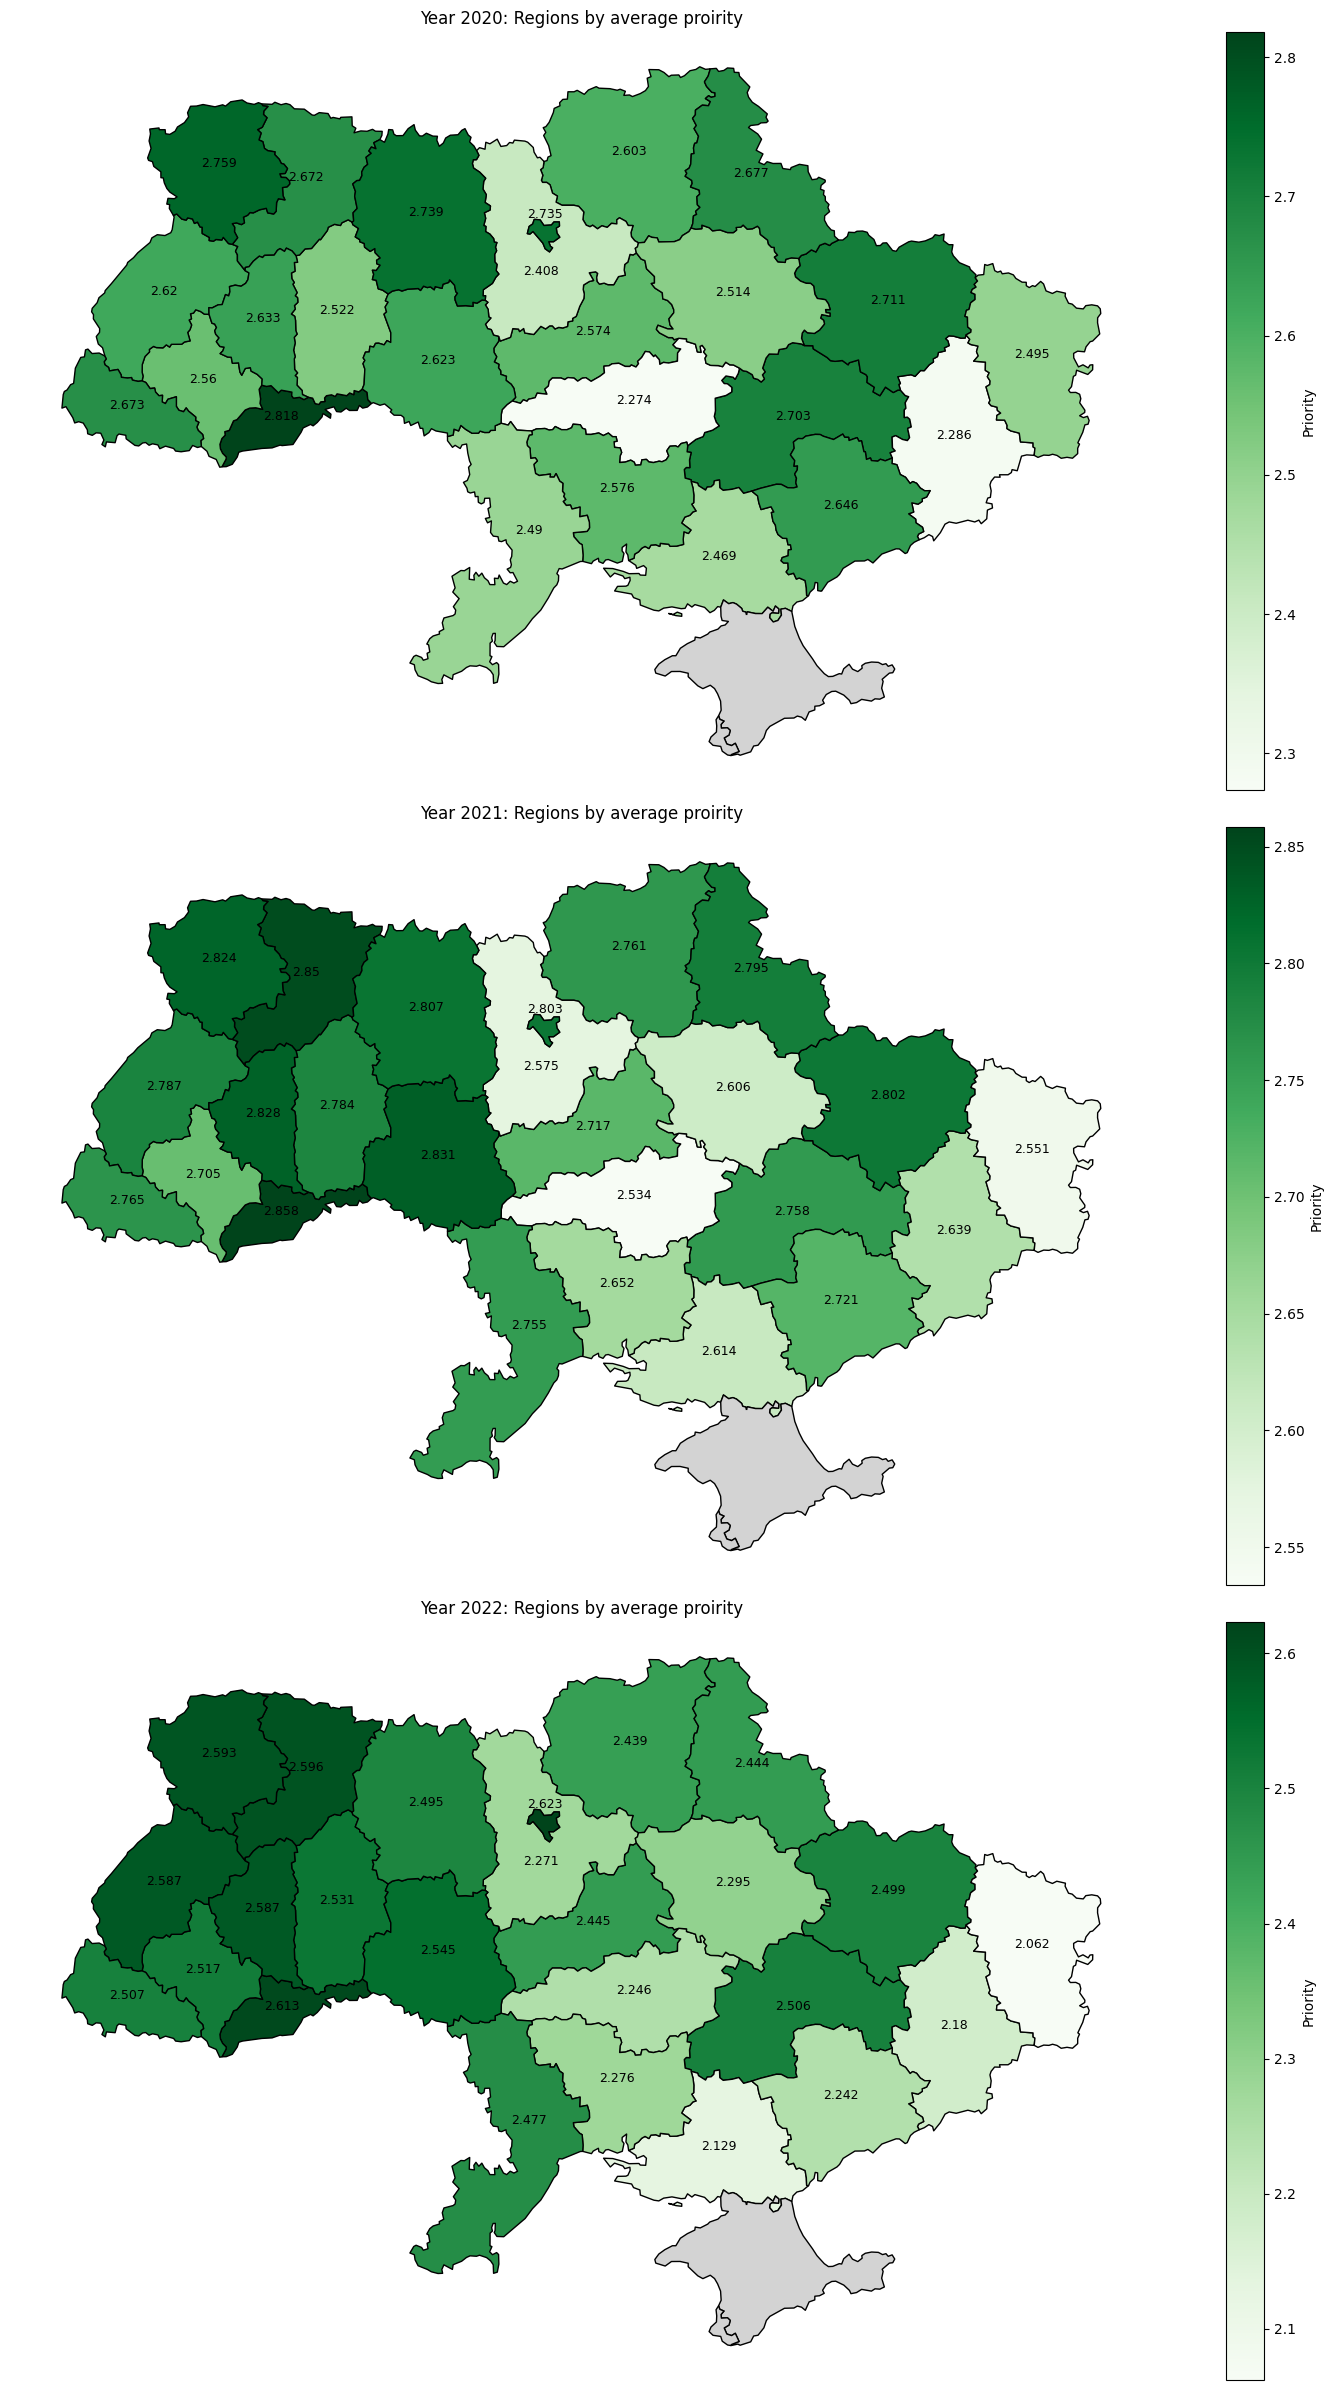

In [11]:
build_maps_regions_by_priority(bachelors, ukraine_map)

In [12]:
def build_maps_regions_by_score(bachelors: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    bachelors = bachelors.copy()
    bachelors['weighted_score'] = bachelors['entered_number'] * bachelors['avg_score_all']
    enrolled_by_regions = bachelors.groupby(['region_name', 'year']).agg(
        weighted_score_sum=('weighted_score', 'sum'),
        entered_number_sum=('entered_number', 'sum')
    ).reset_index()
    enrolled_by_regions['avg_score_by_regions'] = enrolled_by_regions['weighted_score_sum'] / enrolled_by_regions['entered_number_sum'] 
    
    unique_years = enrolled_by_regions['year'].unique()
    fig, axes = plt.subplots(len(unique_years), 1, figsize=(15, 8 * len(unique_years)), sharex=False)
    for i, year in enumerate(unique_years):
        by_year = enrolled_by_regions[enrolled_by_regions['year'] == year]
        ukraine_map_by_year = ukraine_map.merge(by_year, left_on="cyrillic_name", right_on="region_name", how="left")
        ukraine_map_by_year.plot(column='avg_score_by_regions', cmap='Blues', legend=True,  edgecolor='black',
                 legend_kwds={'label': "І", 'orientation': "vertical"}, 
                 ax=axes[i])
        no_value = ukraine_map_by_year[ukraine_map_by_year['avg_score_by_regions'].isna()]
        ukraine_map_by_year_with_value = ukraine_map_by_year[ukraine_map_by_year['avg_score_by_regions'].notna()]
        no_value.plot(color='lightgrey', edgecolor='black', ax=axes[i])
        for idx, row in ukraine_map_by_year_with_value.iterrows():
            x, y = adjust_coordinates(row.geometry.centroid.x, row.geometry.centroid.y, row)
            axes[i].annotate(text=round(row['avg_score_by_regions'], 3), xy=(x, y), 
                         horizontalalignment='center', fontsize=9, color='black')
        axes[i].set_title(f'Year {year}: Regions by average score')
        axes[i].set_aspect(1.5)
        for spine in axes[i].spines.values():
            spine.set_visible(False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.tight_layout()
    plt.show()

In [13]:
def build_map_unequal_access_to_education(bachelors: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(18, 9))
    grouped_by_regions = bachelors.groupby('region_name').agg(
        mean_min_rating_score_budget=('min_rating_score_budget', 'mean')
    ).reset_index()
    ukraine_map = ukraine_map.merge(grouped_by_regions, left_on='cyrillic_name', right_on='region_name', how='left')
    no_value = ukraine_map[ukraine_map['mean_min_rating_score_budget'].isna()]
    ukraine_map_with_value = ukraine_map[ukraine_map['mean_min_rating_score_budget'].notna()]
    no_value.plot(color='lightgrey', edgecolor='black', ax=ax)
    ukraine_map_with_value.plot(column='mean_min_rating_score_budget',cmap='RdYlBu', legend=True,  edgecolor='black',
                 legend_kwds={'label': "Score", 'orientation': "vertical"}, 
                 ax=ax)
    for idx, row in ukraine_map_with_value.iterrows():
            x, y = adjust_coordinates(row.geometry.centroid.x, row.geometry.centroid.y, row)
            ax.annotate(text=f"{round(row['mean_min_rating_score_budget'], 2)}", xy=(x, y), 
                         horizontalalignment='center', fontsize=9, color='black')
    ax.set_aspect(1.5)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('Min score budget by regions')
    plt.show()

## 2) Regions by average score
It turns out that regions with a lower average priority, (3 worse than 2) - 3 lower priority, have higher scores.
Perhaps this is due to the fact that more applications with high scores are sent to such regions - these are people who expect to receive a better education, so submit many applications for admission with different priorities

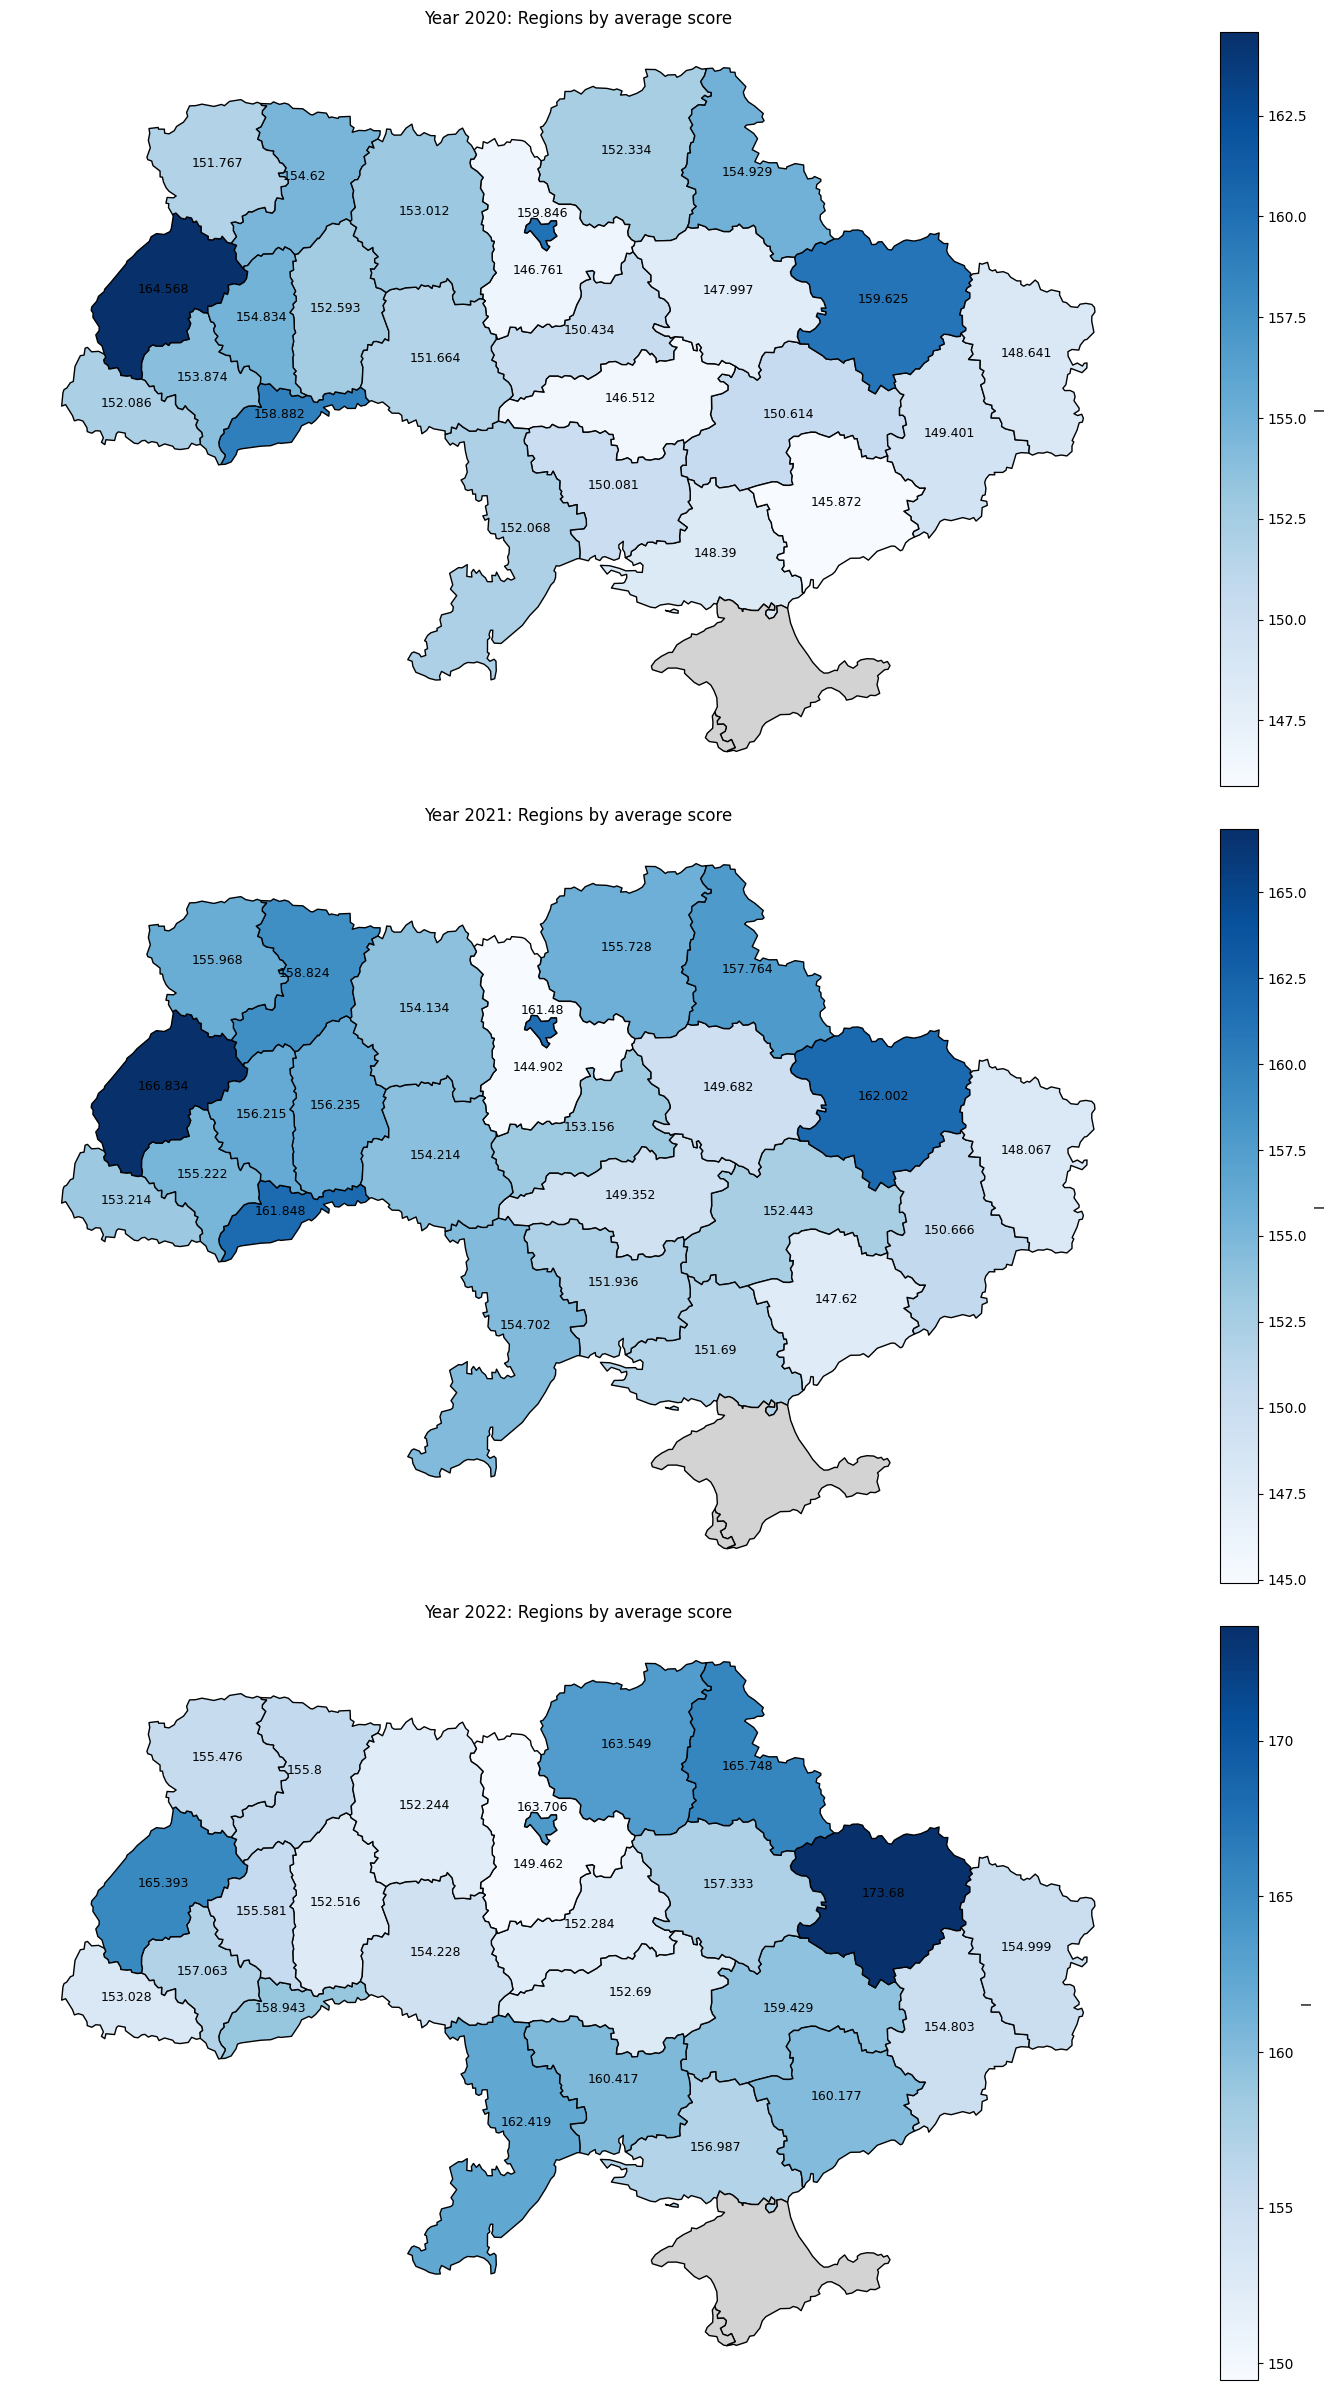

In [14]:
build_maps_regions_by_score(bachelors, ukraine_map)

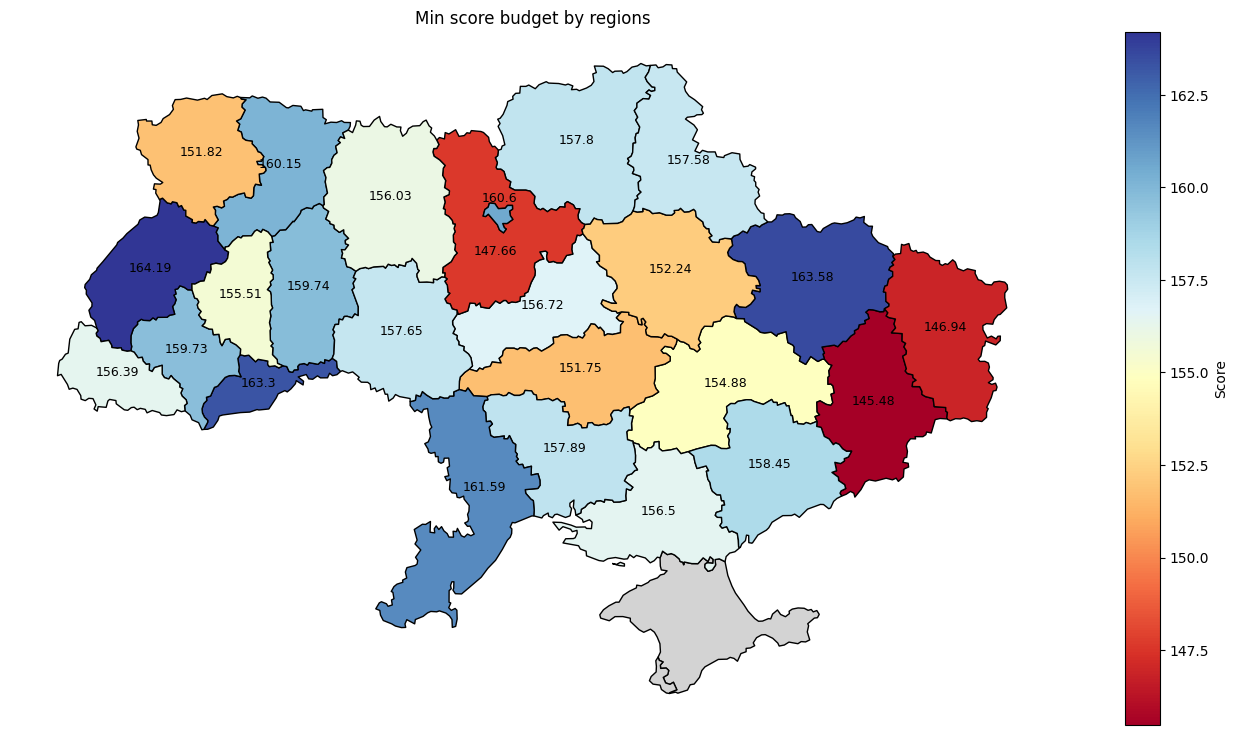

In [15]:
build_map_unequal_access_to_education(bachelors, ukraine_map)

In [16]:
def build_plots_best_universities(bachelors: pd.DataFrame) -> None:
    bachelors = bachelors.copy()
    bachelors['weighted_score'] = bachelors['entered_number'] * bachelors['avg_score_all']
    bachelors = bachelors[(bachelors['area']!='Культура і мистецтво') & (bachelors['area']!='Архітектура та будівництво')]
    grouped_by_universities = bachelors.groupby(['university_name', 'year']).agg(
        weighted_score_sum=('weighted_score', 'sum'),
        entered_number_sum=('entered_number', 'sum')
    ).reset_index()
    grouped_by_universities['avg_score_by_university'] = grouped_by_universities['weighted_score_sum'] / grouped_by_universities['entered_number_sum'] 
    grouped_by_universities = grouped_by_universities[grouped_by_universities['entered_number_sum']>=400]
    
    unique_years = grouped_by_universities['year'].unique()
    fig, axes = plt.subplots(len(unique_years), 1, figsize=(12, 5 * len(unique_years)), sharex=False)
    colors = cm.viridis(np.linspace(0.7, 0.9, len(unique_years)))
    
    for i, (year, color) in enumerate(zip(unique_years, colors)):
        data_for_year = grouped_by_universities[grouped_by_universities['year'] == year].nlargest(10, 'avg_score_by_university')
        
        bars = axes[i].barh(data_for_year['university_name'], data_for_year['avg_score_by_university'], color=color, edgecolor='grey')
    
        if axes[i].get_legend():
            axes[i].get_legend().remove()
        
        for j, bar in enumerate(bars):
            width = bar.get_width() 
            y_position = bar.get_y() + bar.get_height() / 2
            university_name = data_for_year['university_name'].iloc[j]
            
            axes[i].text(101, y_position, university_name, 
                         ha='left', va='center', color='black', 
                         transform=axes[i].transData, fontsize=9.5)
    
        axes[i].set_title(f'Year {year}: Top 10 universities with the highest admission scores')
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('University')
        axes[i].invert_yaxis()
    
        max_score = 205
        axes[i].set_xlim(100, max_score) 
        axes[i].set_xticks(np.arange(100, max_score, step=5))
        axes[i].set_yticklabels([])
    
    plt.tight_layout()
    plt.show()

## 3) Top 10 universities with the highest admission exam scores for the years 2020-2022
The situation is as follows:
In 2020 and 2021, the top did not change much. And in 2022, unexpectedly, 6 out of 10 universities from Kharkiv are in the top. It turned out that a regional coefficient appeared in this area, which increased all points

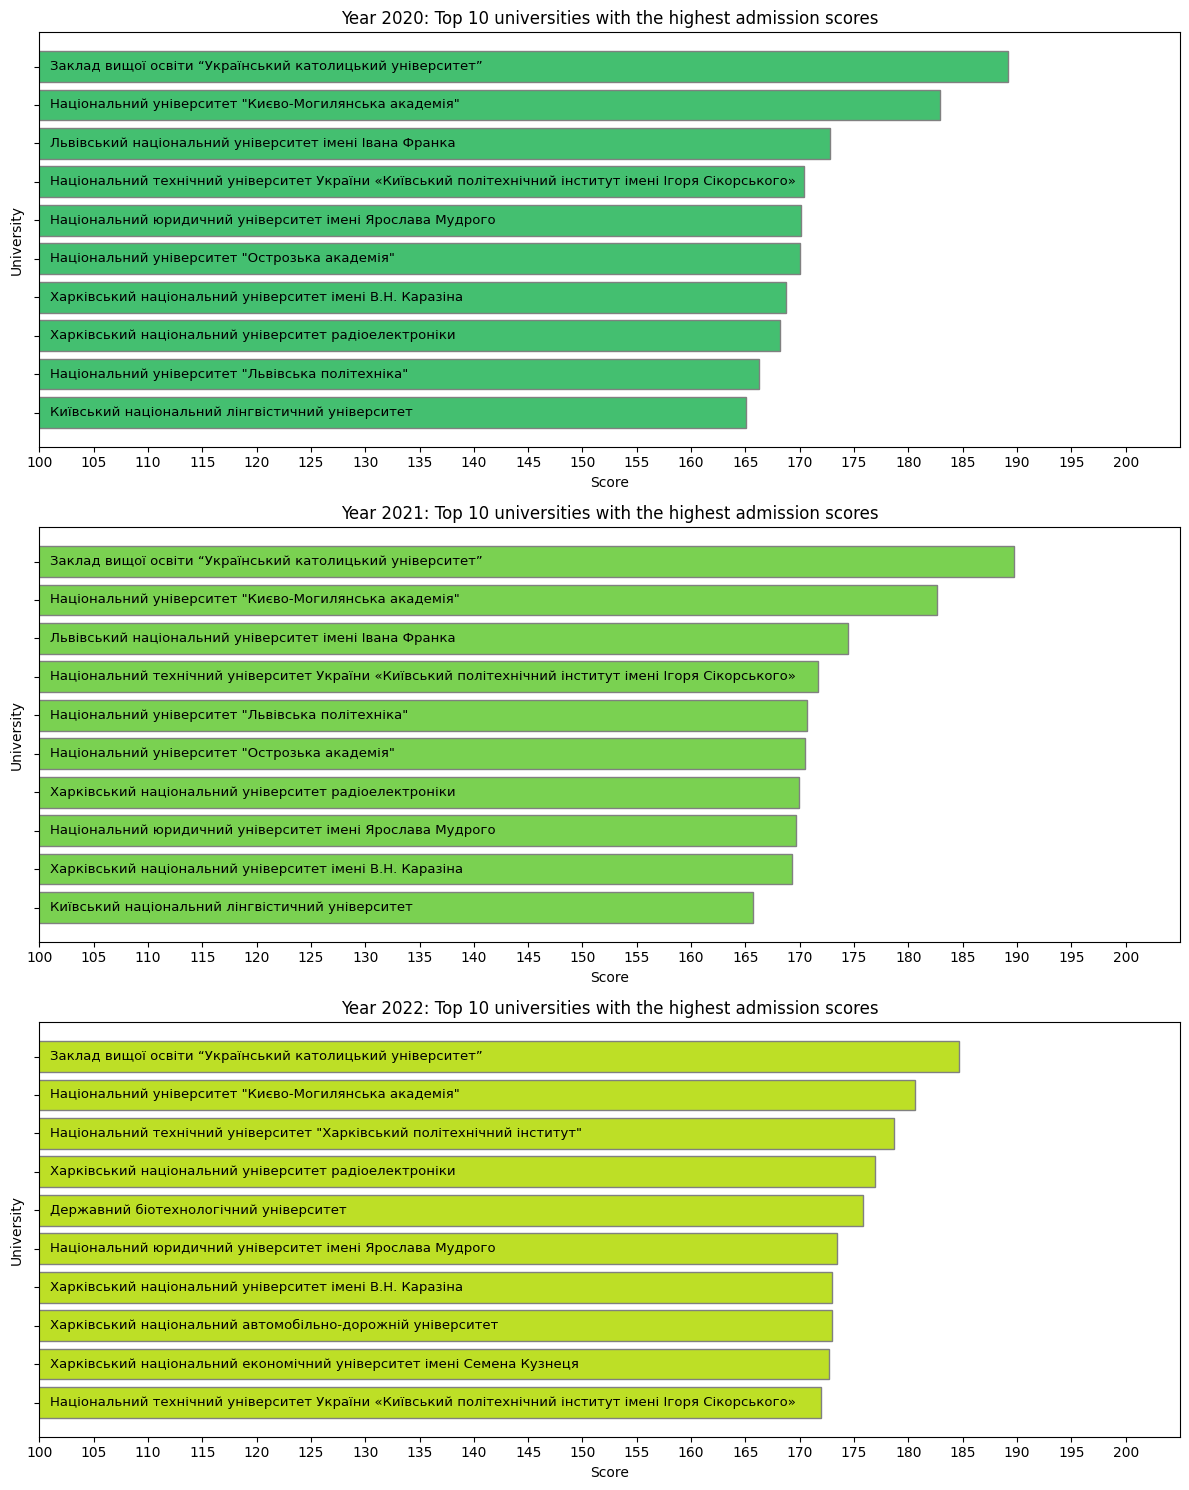

In [17]:
build_plots_best_universities(bachelors)

In [18]:
def build_plots_best_specialities(bachelors: pd.DataFrame) -> None:
    bachelors = bachelors.copy()
    bachelors['weighted_score'] = bachelors['entered_number'] * bachelors['avg_score_all']
    bachelors = bachelors[(bachelors['area']!='Культура і мистецтво') & (bachelors['area']!='Архітектура та будівництво')]
    grouped_bachelors_by_speciality = bachelors.groupby(['speciality_name', 'year']).agg(
        weighted_score_sum=('weighted_score', 'sum'),
        entered_number_sum=('entered_number', 'sum')
    ).reset_index()
    grouped_bachelors_by_speciality['average_score'] = (
        grouped_bachelors_by_speciality['weighted_score_sum'] / 
        grouped_bachelors_by_speciality['entered_number_sum']
    )
    grouped_by_universities = bachelors.groupby(['university_name', 'year']).agg(
        weighted_score_sum=('weighted_score', 'sum'),
        entered_number_sum=('entered_number', 'sum')
    ).reset_index()
    unique_years = grouped_by_universities['year'].unique()
    fig, axes = plt.subplots(len(unique_years), 1, figsize=(12, 5 * len(unique_years)), sharex=False)
    colors = cm.viridis(np.linspace(0.7, 0.9, len(unique_years)))
    
    for i, (year, color) in enumerate(zip(unique_years, colors)):
        data_for_year = grouped_bachelors_by_speciality[grouped_bachelors_by_speciality['year'] == year].nlargest(10, 'average_score')
        
        bars = axes[i].barh(data_for_year['speciality_name'], data_for_year['average_score'], color=color, edgecolor='grey')
    
        if axes[i].get_legend():
            axes[i].get_legend().remove()
        
        for j, bar in enumerate(bars):
            width = bar.get_width() 
            y_position = bar.get_y() + bar.get_height() / 2
            speciality_name = data_for_year['speciality_name'].iloc[j]
            
            axes[i].text(101, y_position, speciality_name, 
                         ha='left', va='center', color='black', 
                         transform=axes[i].transData, fontsize=9.5)
    
        axes[i].set_title(f'Year {year}: Top 10 specialities with the highest admission scores')
        axes[i].set_xlabel('Score')
        axes[i].set_ylabel('Specialities')
        axes[i].invert_yaxis()
    
        max_score = 205
        axes[i].set_xlim(100, max_score) 
        axes[i].set_xticks(np.arange(100, max_score, step=5))
        axes[i].set_yticklabels([])
    
    plt.tight_layout()
    plt.show()

## 4) Top 10 specialties with the highest admission exam scores for the years 2020-2022
There are many unexpected specialties in the top ("Музичне мистецтво", "Хореографія"). This is another creative competition, which is held by the university itself, and not national testing

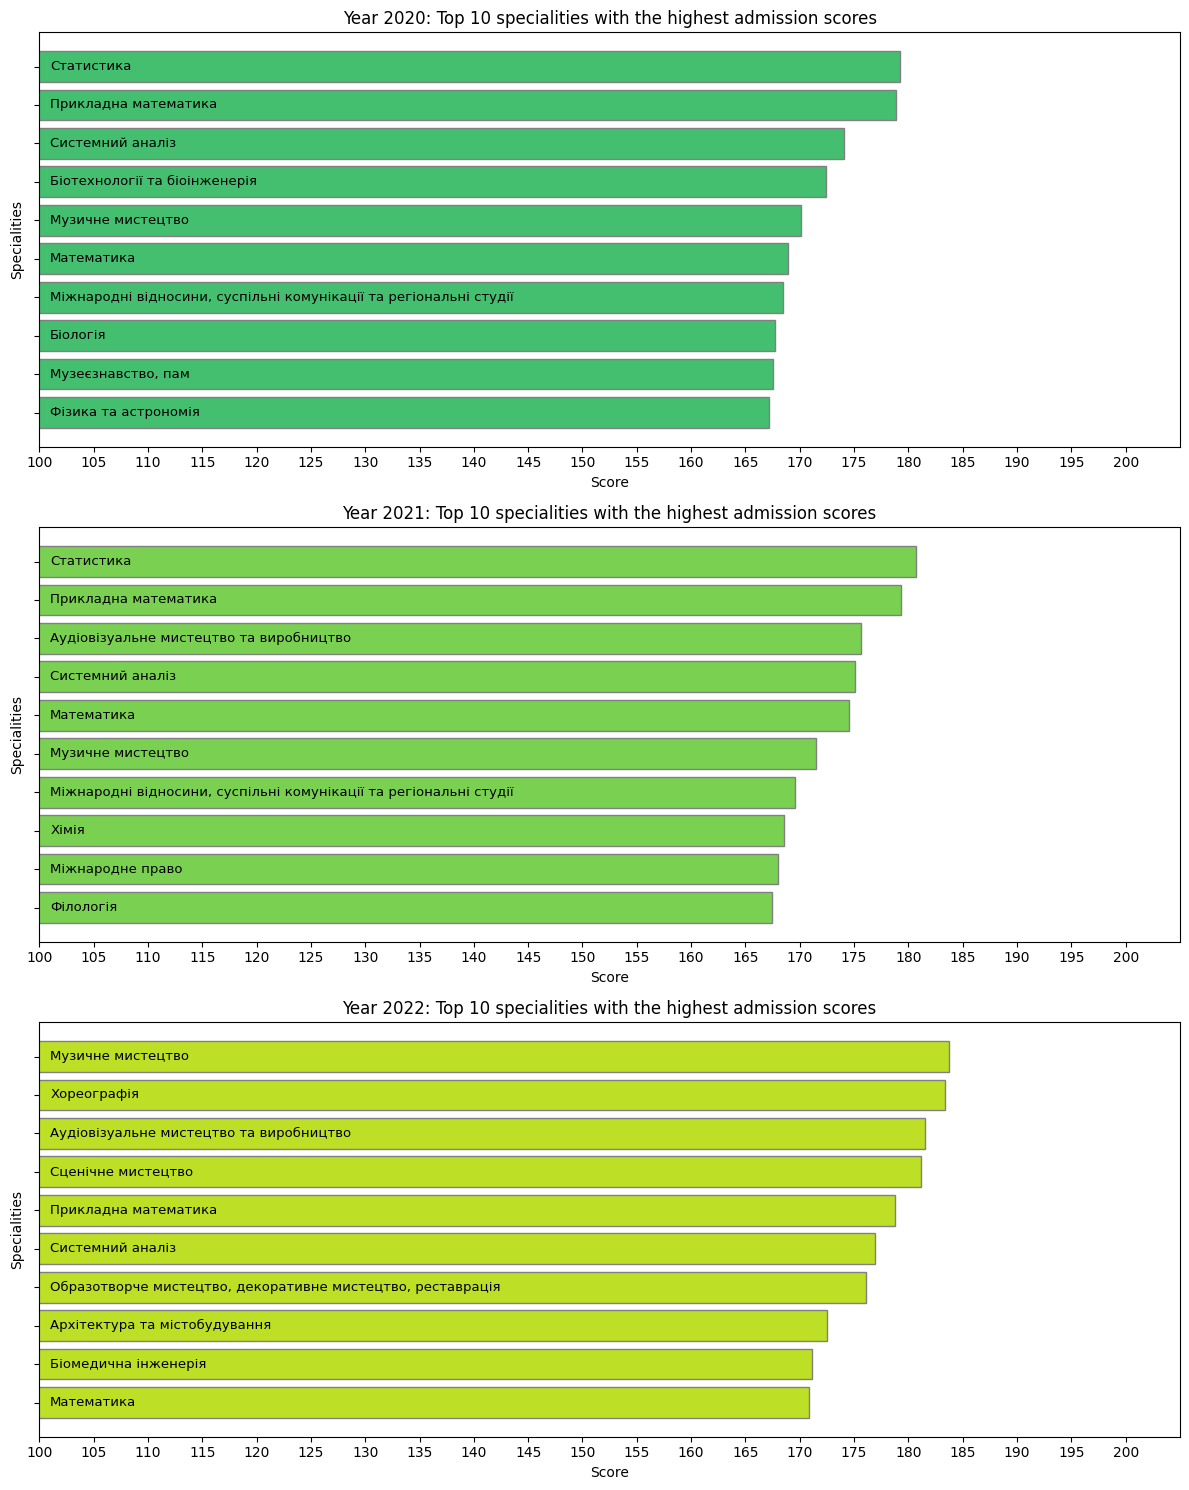

In [19]:
build_plots_best_specialities(bachelors)

In [20]:
def build_plots_distrubition_applications_by_regions(tender_offers: pd.DataFrame) -> None:
    grouped_tender_offers_by_year_by_region = tender_offers.groupby(['region_name', 'year']).agg(
        application_number_sum=('applications_number', 'sum'),
    ).reset_index()
    unique_years = grouped_tender_offers_by_year_by_region['year'].unique()
    
    fig, axes = plt.subplots(len(unique_years), 1, figsize=(10, 10 * len(unique_years)))
    for i, year in enumerate(unique_years):
        data_for_year = grouped_tender_offers_by_year_by_region[grouped_tender_offers_by_year_by_region['year']==year]
        data_for_year = data_for_year.sort_values(by="application_number_sum", ascending=False)
        top_10 = data_for_year.head(9)
        others_sum = data_for_year['application_number_sum'].iloc[9:].sum()
        if others_sum > 0:
            others_row = pd.DataFrame({
                    'region_name': ['others'],
                    'application_number_sum': [others_sum],
                    'year': [year]
            })
            top_10 = pd.concat([top_10, others_row], ignore_index=True)
        region_names = top_10['region_name']
        application_sum = top_10['application_number_sum']
    
        wedges, texts, autotexts  = axes[i].pie(application_sum,  autopct='%1.1f%%', startangle=-20)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")
    
        for j, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            
            axes[i].annotate(region_names[j], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                        horizontalalignment=horizontalalignment, **kw)
    
        colors = plt.get_cmap('tab20', len(top_10))
        color_list = [colors(j) for j in range(len(top_10)-1)] + [(0.5, 0.5, 0.5, 1)] 
    
        axes[i].set_title(f"Distribution of applications by region in {year} year")
        axes[i].axis('equal')
        
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.2)
    plt.show()

In [21]:
def build_map_distribution_of_apps_by_regions(tender_offers: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    grouped_by_years = tender_offers.groupby(['region_name', 'year']).agg(
        sum_applications_number=('applications_number', 'sum')
    ).reset_index()
    fig, ax = plt.subplots(1, 1, figsize=(28, 20))
    ukraine_map.plot(ax=ax, color="white", edgecolor="black")
    ax.set_title(f'Distribution of apllications by regions')
    ax.set_aspect(1.5)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    for _, region in ukraine_map.iterrows():
            region_name = region['cyrillic_name']
            region_data = grouped_by_years[grouped_by_years['region_name'] == region_name]
            
            if not region_data.empty:
                x, y = region.geometry.centroid.x, region.geometry.centroid.y
                if region['cyrillic_name'] == "Київська область":
                    y -= 0.38
                    x -= 0.22
                elif region['cyrillic_name'] == "Київ":
                    y += 0.29
                    x -= 0.15
                ax_inset = inset_axes(
                    ax,
                    width="750%",  
                    height="550%",  
                    loc='center',
                    bbox_to_anchor=(x, y, 0.1, 0.1),  
                    bbox_transform=ax.transData,  
                    borderpad=0,
                )
                ax_inset.bar(region_data['year'], region_data['sum_applications_number'], color="powderblue", alpha=0.8, edgecolor="black")
                ax_inset.set_facecolor("whitesmoke")
                
                # Додаємо підписи до осей
                ax_inset.set_xlabel("Year", fontsize=8, labelpad=2)
                ax_inset.set_ylabel("Applications", fontsize=8, labelpad=2)
                
                # Розміщення підписів
                ax_inset.xaxis.set_tick_params(labelsize=6, rotation=45)
                ax_inset.yaxis.set_tick_params(labelsize=6)



## 5) Distribution of enrollment applications by region for 2020-2024
Almost nothing has changed over the years. Just one moment, in 2022, Kharkiv oblast took second place (10.2% -> 7.5%), and Lviv took its place (9.8% -> 10.9).
And in 2024, Dnipropetrovsk region overtook Kharkiv region

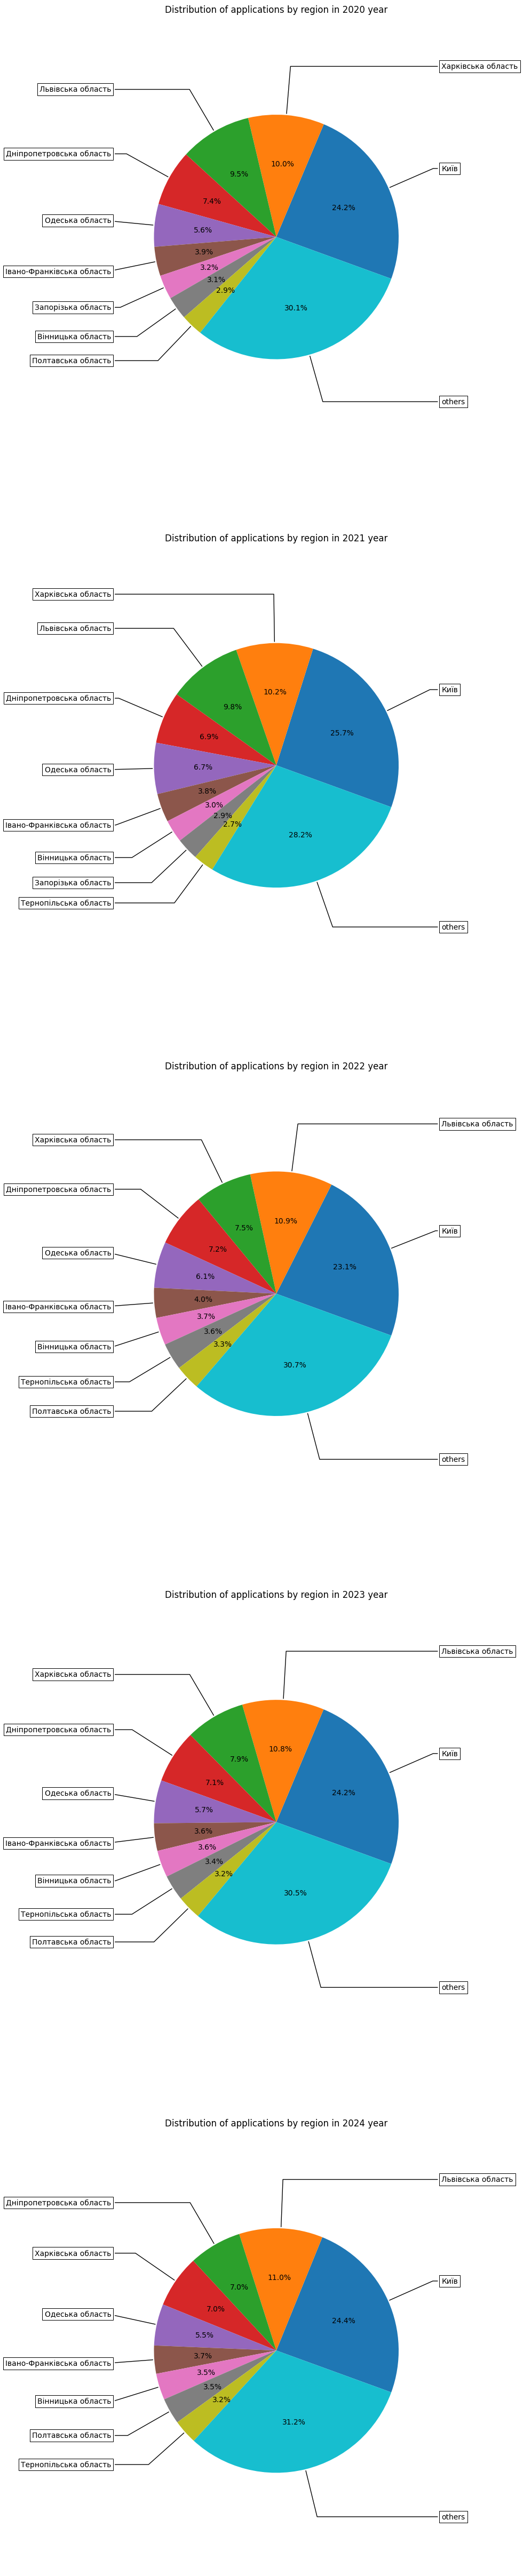

In [22]:
build_plots_distrubition_applications_by_regions(tender_offers)

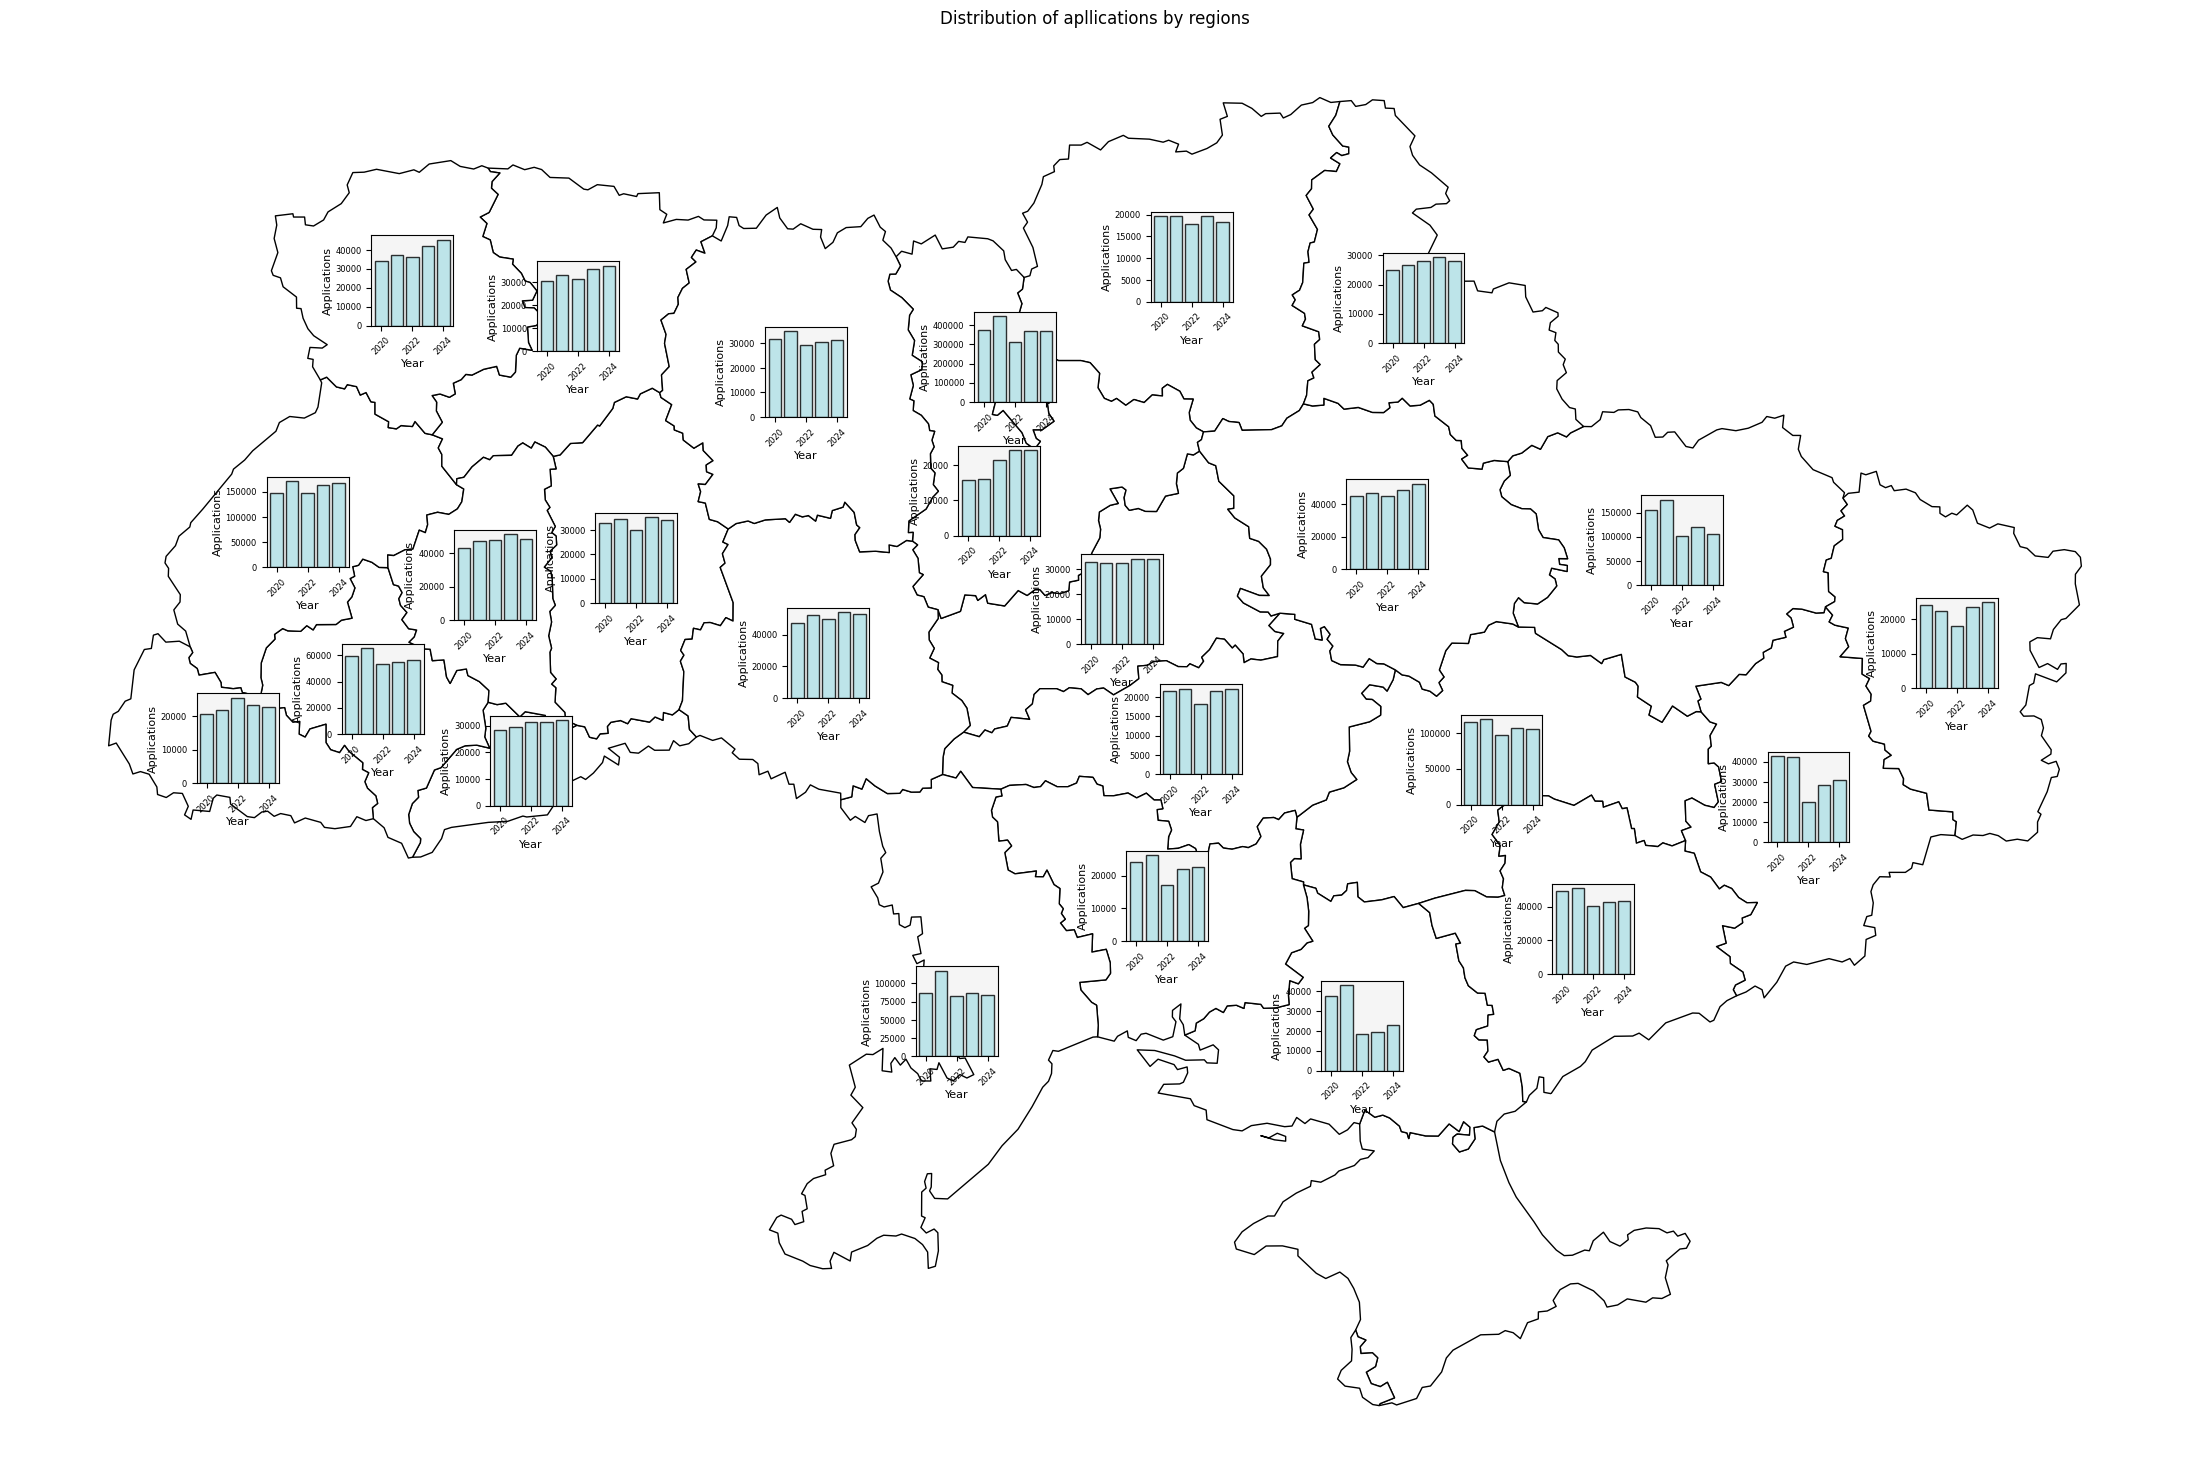

In [23]:
build_map_distribution_of_apps_by_regions(tender_offers, ukraine_map)

In [24]:
def build_plots_distribution_applications_by_education_level(tender_offers: pd.DataFrame) -> None:
    grouped_by_education_level_by_year = tender_offers.groupby(['education_level', 'year']).agg(
        application_number_sum=('applications_number', 'sum'),
    ).reset_index()
    unique_years = grouped_by_education_level_by_year['year'].unique()
    unique_levels = grouped_by_education_level_by_year['education_level'].unique()
    
    data_pivot = grouped_by_education_level_by_year.pivot(index='year', columns='education_level', values='application_number_sum')
    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.15
    x = np.arange(len(unique_years))
    
    for i, year in enumerate(unique_levels):
        year_data = data_pivot[year].fillna(0)  
        ax.bar(x + i * bar_width, year_data, width=bar_width, label=f'{year}')
    
    ax.set_xticks(x + bar_width * (len(unique_years) - 1) / 2)
    ax.set_xticklabels(unique_years, rotation=45, ha='right')
    ax.set_ylabel('Number of Applications')
    ax.set_title('Distribution by Educational Levels Across Years')
    ax.legend(title='Educational level')
    
    plt.tight_layout()
    plt.show()

## 6) Distribution of enrollment applications by education levels for 2020-2024
Starting in 2022, the total number of applications decreased, while the percentage of master's applicants increased significantly, and remains at a higher level than before the invasion

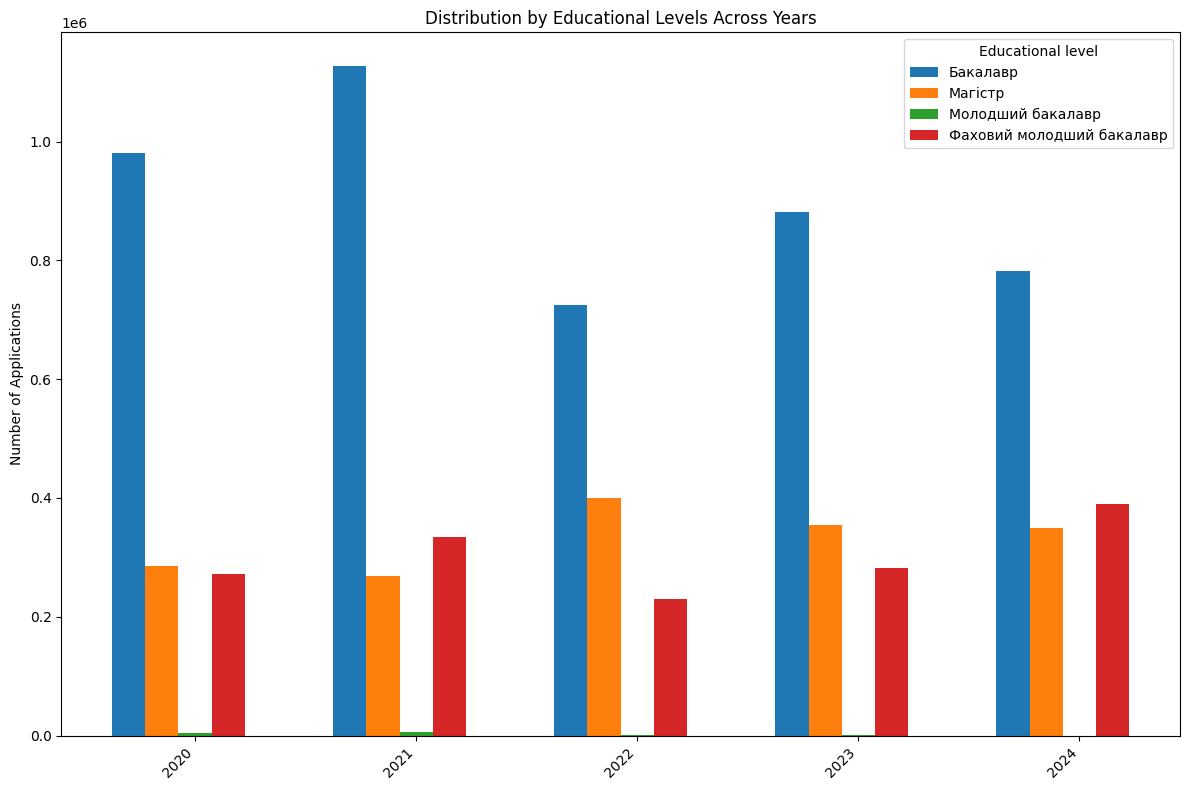

In [25]:
build_plots_distribution_applications_by_education_level(tender_offers)

In [26]:
def build_plots_distribution_budget_conract(df: pd.DataFrame) -> None:
    grouped_by_years = df.groupby('year').agg(
        sum_total_enrolled_budget=('total_enrolled_budget', 'sum'),
        sum_total_enrolled_contract=('total_enrolled_contract', 'sum')
    )
    pivot_data = df.pivot_table(
        index='year', 
        values=['total_enrolled_budget', 'total_enrolled_contract'], 
        aggfunc='sum'
    ).reset_index()
    fig, ax = plt.subplots(figsize=(12, 8))
    pivot_data.plot(
        x='year', 
        y=['total_enrolled_budget', 'total_enrolled_contract'], 
        kind='bar', 
        ax=ax, 
        width=0.8,
        color=['skyblue', 'salmon']
    )
    ax.set_title('Distribution of Budget vs Contract Enrollments by Year', fontsize=16)
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Number of Enrollments', fontsize=14)
    ax.legend(['Budget', 'Contract'], title='Enrollment Type')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 7) Distribution by number of entrants per budget and contract (2020-2022)
Unexpectedly, the number of people who entered educational institutions in 2022 turned out to be greater than in 2020 or 2021. But it should be taken into account that these are also entrants to master’s degrees, younger than bachelor’s and specialist

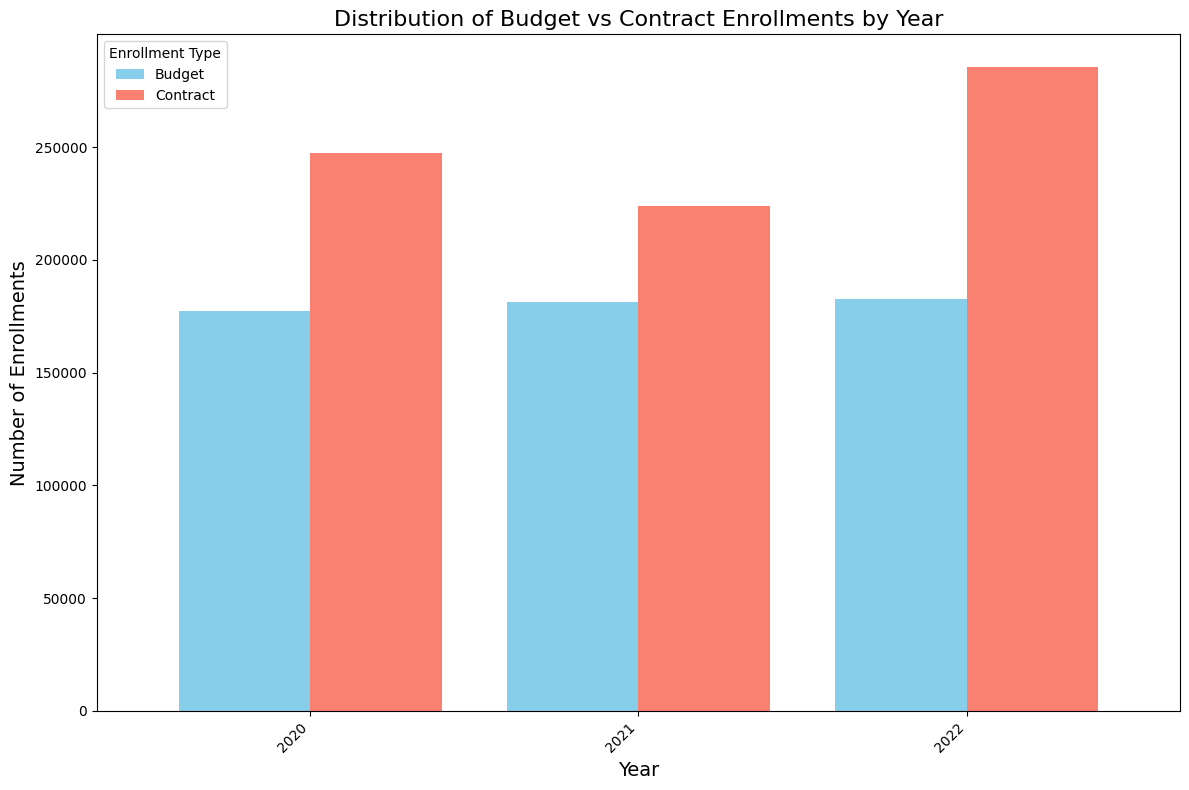

In [27]:
build_plots_distribution_budget_conract(df)

In [28]:
def generate_color_palettes(regions):
    region_specific_palettes = {
        'Львівська область': 'Blues',
        'Харківська область': 'Reds',
        'Київ': 'Greens',
        'Івано-Франківська область': 'Purples',
        'Чернівецька область': 'Oranges'
    }
    
    default_palette = 'Greys'
    
    color_palettes = {}
    for region in regions:
        if region in region_specific_palettes:
            cmap_name = region_specific_palettes[region]
        else:
            cmap_name = default_palette
        
        cmap = plt.get_cmap(cmap_name)
        color_palettes[region] = cmap
    
    return color_palettes

def build_plots_distribution_applications_by_universities(tender_offers: pd.DataFrame) -> None:
    grouped_tender_offers_by_universities = tender_offers.groupby(['university_name', 'region_name', 'year']).agg(
        application_number_sum=('applications_number', 'sum'),
    ).reset_index()
    unique_years = grouped_tender_offers_by_universities['year'].unique()
    unique_regions = grouped_tender_offers_by_universities['region_name'].unique()
    region_color_maps = generate_color_palettes(unique_regions)
    
    fig, axes = plt.subplots(
        len(unique_years), 2, figsize=(20, 10 * len(unique_years)),
        gridspec_kw={'width_ratios': [8, 2]}
    )
    
    for i, year in enumerate(unique_years):
        data_for_year = grouped_tender_offers_by_universities[grouped_tender_offers_by_universities['year'] == year]
        data_for_year = data_for_year.sort_values(by="application_number_sum", ascending=False)
        
        top_10 = data_for_year.head(10)
        others_sum = data_for_year['application_number_sum'].iloc[10:].sum()
        
        university_names = top_10['university_name']
        application_sum = top_10['application_number_sum']
        regions = top_10['region_name']
        
        sum_of_all_applications = data_for_year['application_number_sum'].sum()
        percentage_of_top_10 = sum(application_sum) / sum_of_all_applications
        
        max_width = 25
        formatted_names = [textwrap.fill(name, width=max_width) for name in university_names]
        labels = [f"{name}\n{value} ({value / sum_of_all_applications * 100:.1f}%)"
                  for name, value in zip(formatted_names, application_sum)]
        
        region_colors_list = [
            region_color_maps[region](0.6) 
            for i, region in enumerate(regions)
        ]
        
        squarify.plot(
            sizes=application_sum,
            label=labels,
            color=region_colors_list,
            alpha=0.8,
            ax=axes[i, 0],
            text_kwargs={'fontsize': 13},
            linewidth=1,
            edgecolor='black' 
        )
        axes[i, 0].set_title(f"Top 10 Universities in {year} ({round(percentage_of_top_10 * 100, 2)}%)", fontsize=26)
        axes[i, 0].axis('off')
        
        category_sizes = [sum(application_sum), others_sum]
        category_labels = [f"Top 10\n({round(percentage_of_top_10 * 100, 1)}%)", 
                           f"Others\n({round((others_sum / sum_of_all_applications) * 100, 1)}%)"]
        squarify.plot(
            sizes=category_sizes,
            label=category_labels,
            color=['#89CFF0', '#FF6961'],
            alpha=0.7,
            ax=axes[i, 1],
            text_kwargs={'fontsize': 20},
            linewidth=1,
            edgecolor='black' 
        )
        axes[i, 1].set_title(f"Top 10 vs Others in {year}", fontsize=20)
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.15)
    plt.show()

## 8) Distribution of enrollment applications by universities for 2020-2024
From 2022, the rating will be headed by Lviv educational institutions. Kharkiv establishments have disappeared.
Interestingly, nine universities cover 20% of all applications, while the other 1,219 cover 80%

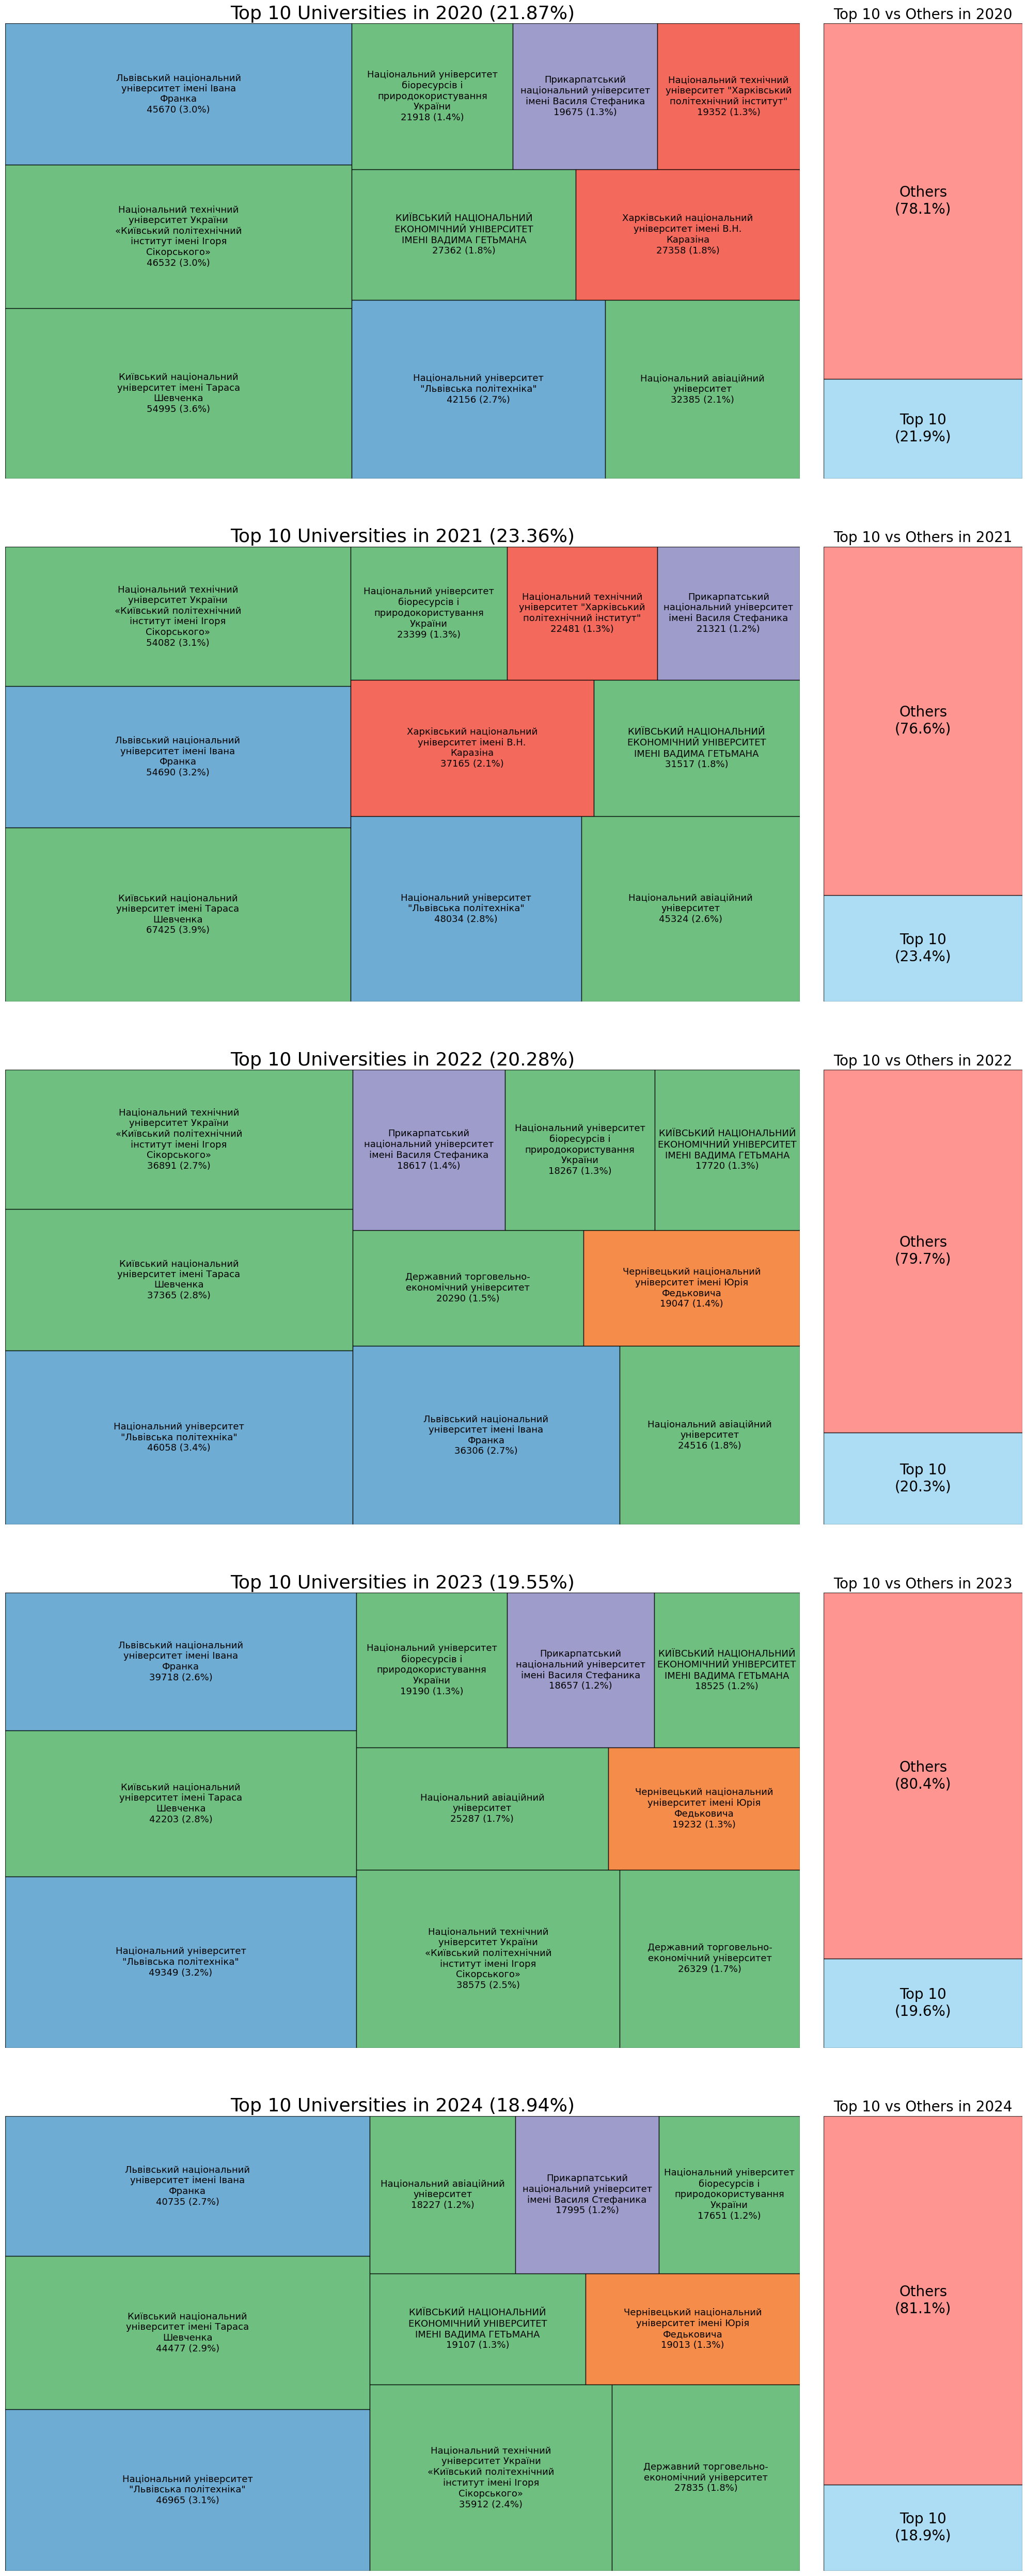

In [29]:
build_plots_distribution_applications_by_universities(tender_offers)

In [30]:
def build_plot_distribution_students_by_avg_score(df: pd.DataFrame) -> None:
    unique_years = df['year'].unique()
    unique_years.sort()

    plt.figure(figsize=(12, 8))

    for year in unique_years:
        yearly_data = df[df['year'] == year].copy()
        
        bins = np.arange(100, yearly_data['avg_score_all'].max() + 5, 5)
        yearly_data.loc[:, 'score_interval'] = pd.cut(yearly_data['avg_score_all'], bins) 
        
        grouped = yearly_data.groupby('score_interval', observed=False)['entered_number'].sum()
        plt.plot(grouped.index.astype(str), grouped.values, label=f'Year {year}')
    
    plt.title('Students distribution by scores', fontsize=16)
    plt.xlabel('Interval of scores', fontsize=14)
    plt.ylabel('Students number', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title='Year')
    plt.tight_layout()
    plt.show()

## 9) Distribution of students by points (2020-2022)
A certain normal distribution is obtained. In 2022, there were fewer students with low scores due to a more lenient grading system

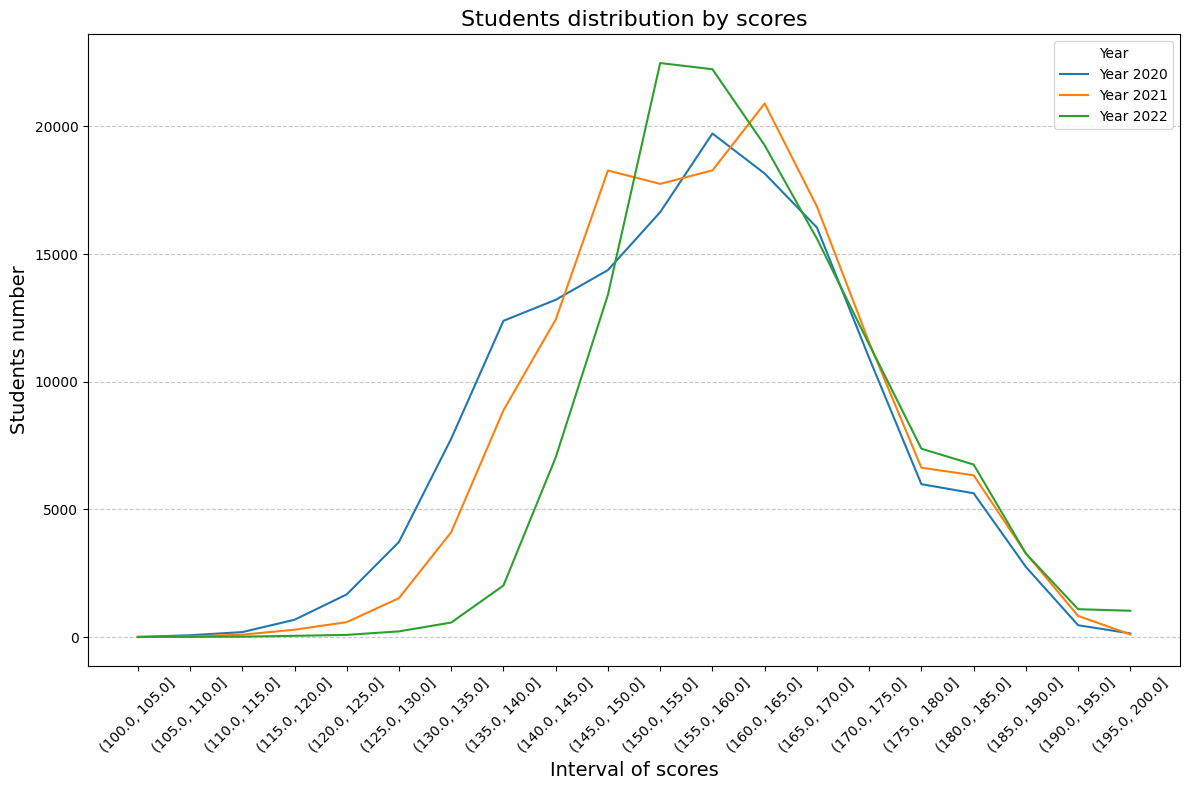

In [31]:
build_plot_distribution_students_by_avg_score(bachelors)

In [32]:
def build_plots_distribution_applications_by_area(tender_offers: pd.DataFrame) -> None:
    grouped_tender_offers_by_area = tender_offers.groupby(['area', 'year']).agg(
        application_number_sum=('applications_number', 'sum'),
    ).reset_index()
    unique_years = grouped_tender_offers_by_area['year'].unique()
    fig, axes = plt.subplots(len(unique_years), 1, figsize=(6, 9* len(unique_years)))
    for i, year in enumerate(unique_years):
        data_for_year = grouped_tender_offers_by_area[grouped_tender_offers_by_area['year']==year]
        data_for_year = data_for_year.sort_values(by="application_number_sum", ascending=False)
        top_10 = data_for_year.head(9)
        others_sum = data_for_year['application_number_sum'].iloc[9:].sum()
        if others_sum > 0:
            others_row = pd.DataFrame({
                    'area': ['others'],
                    'application_number_sum': [others_sum],
                    'year': [year]
            })
            top_10 = pd.concat([top_10, others_row], ignore_index=True)
        area_names = top_10['area']
        application_sum = top_10['application_number_sum']
        wedges, texts, autotexts  = axes[i].pie(application_sum,  autopct='%1.1f%%', startangle=-40)
        bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
        kw = dict(arrowprops=dict(arrowstyle="-"), bbox=bbox_props, zorder=0, va="center")
        for j, p in enumerate(wedges):
            ang = (p.theta2 - p.theta1)/2. + p.theta1
            y = np.sin(np.deg2rad(ang))
            x = np.cos(np.deg2rad(ang))
            horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
            connectionstyle = f"angle,angleA=0,angleB={ang}"
            kw["arrowprops"].update({"connectionstyle": connectionstyle})
            
            axes[i].annotate(area_names[j], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                        horizontalalignment=horizontalalignment, fontsize=12, **kw)
        colors = plt.get_cmap('tab20', len(top_10))
        color_list = [colors(j) for j in range(len(top_10)-1)] + [(0.5, 0.5, 0.5, 1)] 
        axes[i].set_title(f"Distribution of applications by area in {year} year")
        axes[i].axis('equal')
    plt.subplots_adjust(hspace=0.2)
    plt.show()

## 10) Distribution of enrollment applications by area for 2020-2024
Over the years, there was no change. I just want to note that 40% of all applications in the country were submitted for Engineering and Electronics

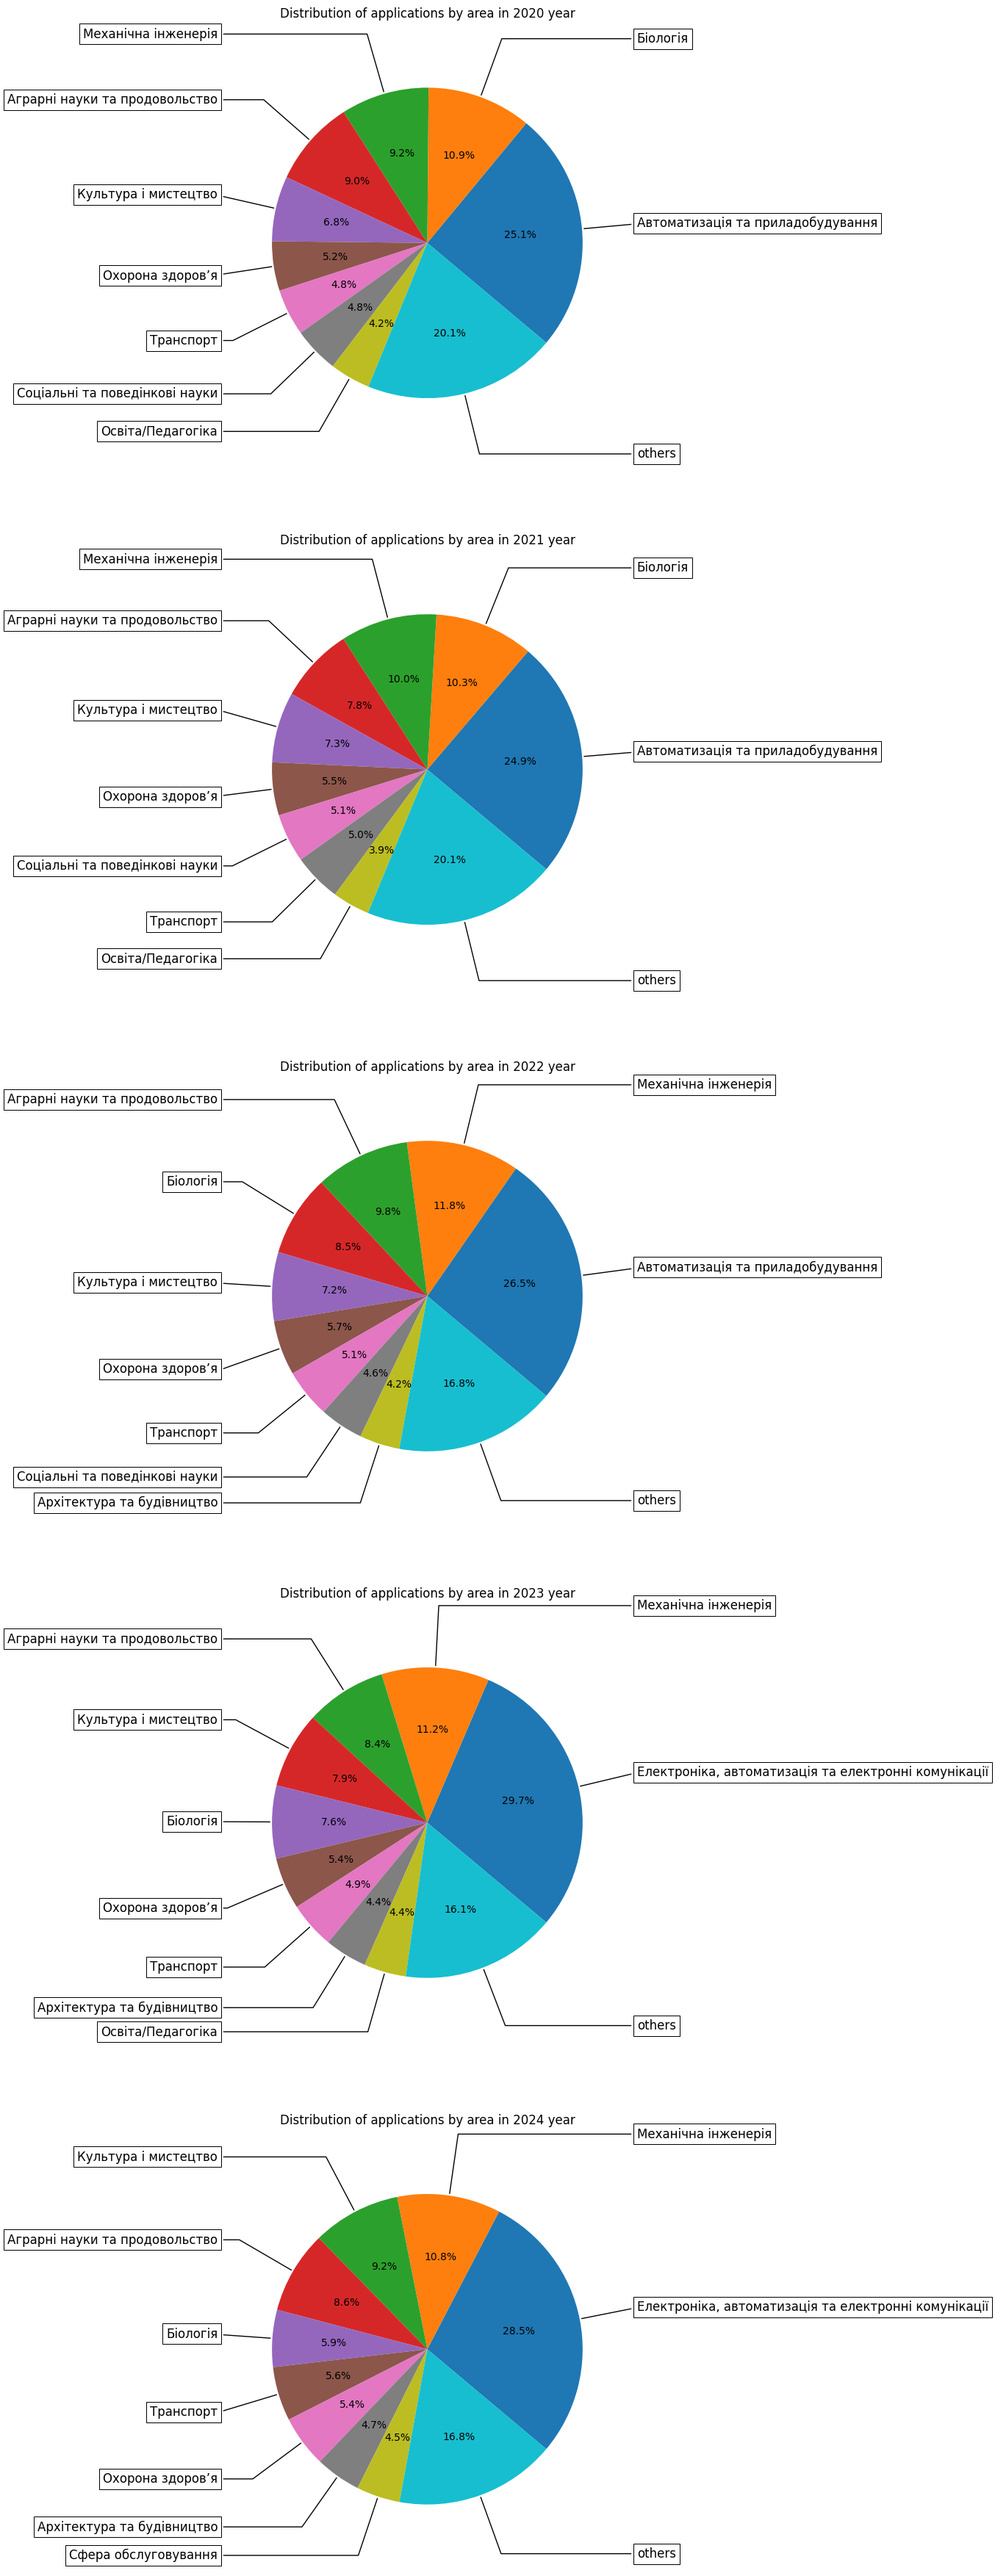

In [33]:
build_plots_distribution_applications_by_area(tender_offers)

In [34]:
def build_plots_popular_specialities(tender_offers: pd.DataFrame) -> None:
    grouped_tender_offers_by_specialities = tender_offers.groupby(['speciality_code', 'speciality_name', 'year']).agg(
        application_number_sum=('applications_number', 'sum'),
    ).reset_index()

    all_top_specialities = set()
    unique_years = grouped_tender_offers_by_specialities['year'].unique()
    for year in unique_years:
        data_for_year = grouped_tender_offers_by_specialities[grouped_tender_offers_by_specialities['year'] == year]
        top_specialities = data_for_year.nlargest(10, 'application_number_sum')[['speciality_name', 'speciality_code']]
        for _, row in top_specialities.iterrows():
            speciality_label = f"{row['speciality_name']} {row['speciality_code']}"
            all_top_specialities.add(speciality_label)
    pastel_palette = plt.cm.tab20(np.linspace(0, 1, len(all_top_specialities)))
    speciality_color_map = dict(zip(all_top_specialities, pastel_palette))

    fig, axes = plt.subplots(len(unique_years), 1, figsize=(12, 7 * len(unique_years)), sharex=False)

    for i, year in enumerate(unique_years):
        data_for_year = grouped_tender_offers_by_specialities[
            grouped_tender_offers_by_specialities['year'] == year
        ].nlargest(10, 'application_number_sum')

        sizes = data_for_year['application_number_sum'].values
        labels = [textwrap.fill(f"{row['speciality_name']} {row['speciality_code']}\n({row['application_number_sum']})", width=20) 
                  for _, row in data_for_year.iterrows()]
        
        colors = [speciality_color_map[f"{row['speciality_name']} {row['speciality_code']}"] for _, row in data_for_year.iterrows()]

        squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, ax=axes[i], text_kwargs={'fontsize': 9}, pad=5)

        axes[i].set_title(f'Year {year}: Top 10 specialities by amount of applications')
        axes[i].set_axis_off()

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.19)
    plt.show()

## 11) Top 10 specialties by the number of enrollment applications for 2020-2024
Over the years, there has been no change. I would like to emphasize that although these are the most popular specialties, they do not belong to the fields from the top, which is higher

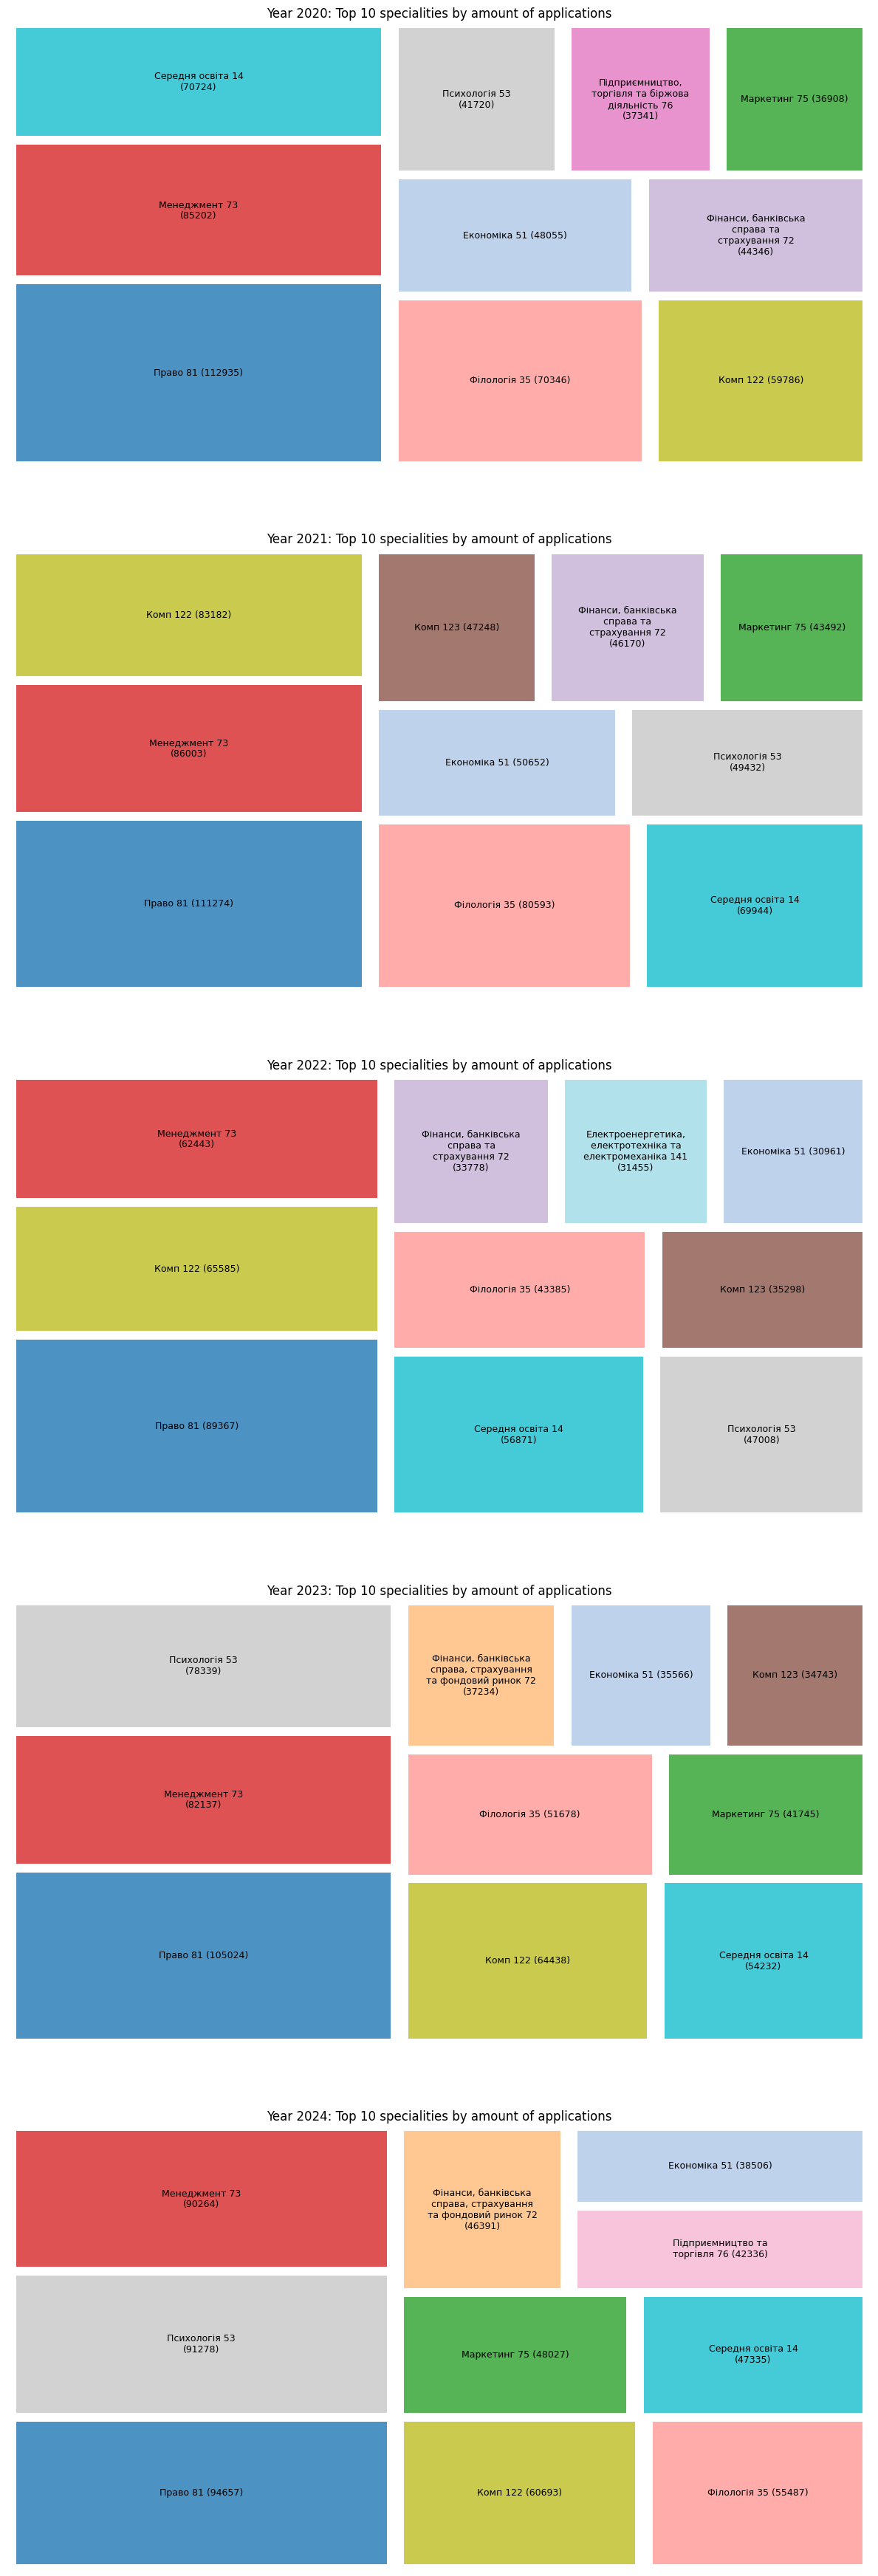

In [35]:
build_plots_popular_specialities(tender_offers)

In [36]:
def build_plots_distribution_appliacations_by_parts_of_ukraine(tender_offers: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    grouped_tender_offers_by_year_by_part = tender_offers.copy()
    grouped_tender_offers_by_year_by_part["part"] = tender_offers["region_name"].map(region_to_part_of_ukraine)
    grouped_by_parts_of_ukraine = grouped_tender_offers_by_year_by_part.groupby(['part', 'year']).agg(
        application_number_sum=('applications_number', 'sum'),
    ).reset_index()
    
    total_applications_by_year = grouped_by_parts_of_ukraine.groupby('year')['application_number_sum'].sum().reset_index()
    total_applications_by_year.rename(columns={'application_number_sum': 'total_applications'}, inplace=True)
    grouped_by_parts_of_ukraine = pd.merge(grouped_by_parts_of_ukraine, total_applications_by_year, on='year')
    grouped_by_parts_of_ukraine['percentage'] = (
        grouped_by_parts_of_ukraine['application_number_sum'] / 
        grouped_by_parts_of_ukraine['total_applications']
    ) * 100
    unique_years = grouped_by_parts_of_ukraine['year'].unique()
    regions_map = ukraine_map.dissolve(by='part')
    part_colors = {
        'Центр': 'lightgreen',
        'Захід': 'lightblue',
        'Схід': 'lightcoral',
        'Південь': 'lightyellow',
    }
    regions_map['centroid'] = regions_map.geometry.apply(lambda geom: geom.centroid)
    regions_map['centroid'] = regions_map.geometry.apply(lambda geom: geom.centroid)
    fig, axes = plt.subplots(nrows=len(unique_years), ncols=1, figsize=(50, 50), sharex=True, sharey=True)
    for i, year in enumerate(unique_years):
        regions_map.plot(ax=axes[i], color=regions_map.index.map(part_colors), edgecolor='black')
        
        for part, row in regions_map.iterrows():
            centroid = row['centroid']
            y = centroid.y
            if part == "Південь": 
                y += 0.57
            percentage = grouped_by_parts_of_ukraine[(grouped_by_parts_of_ukraine['year']==year) & (grouped_by_parts_of_ukraine['part']==part)]['percentage'].iloc[0]
            percentage = round(percentage, 1)
            text = f"{part}\n({percentage}%)"
            axes[i].text(centroid.x, y, text, fontsize=14, ha='center', color='black', weight='bold')
        
        axes[i].set_aspect(1.5)
        for spine in axes[i].spines.values():
            spine.set_visible(False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Applications by part of Ukraine in {year}", fontsize=16) 
    plt.show()

## 12) Map of enrollment application distribution by parts of Ukraine (West, East, South, Center). Identify changes since February 24.
After 2022, the number of applications in eastern regions decreased (25% -> 20%), and in western regions (25% -> 30%)

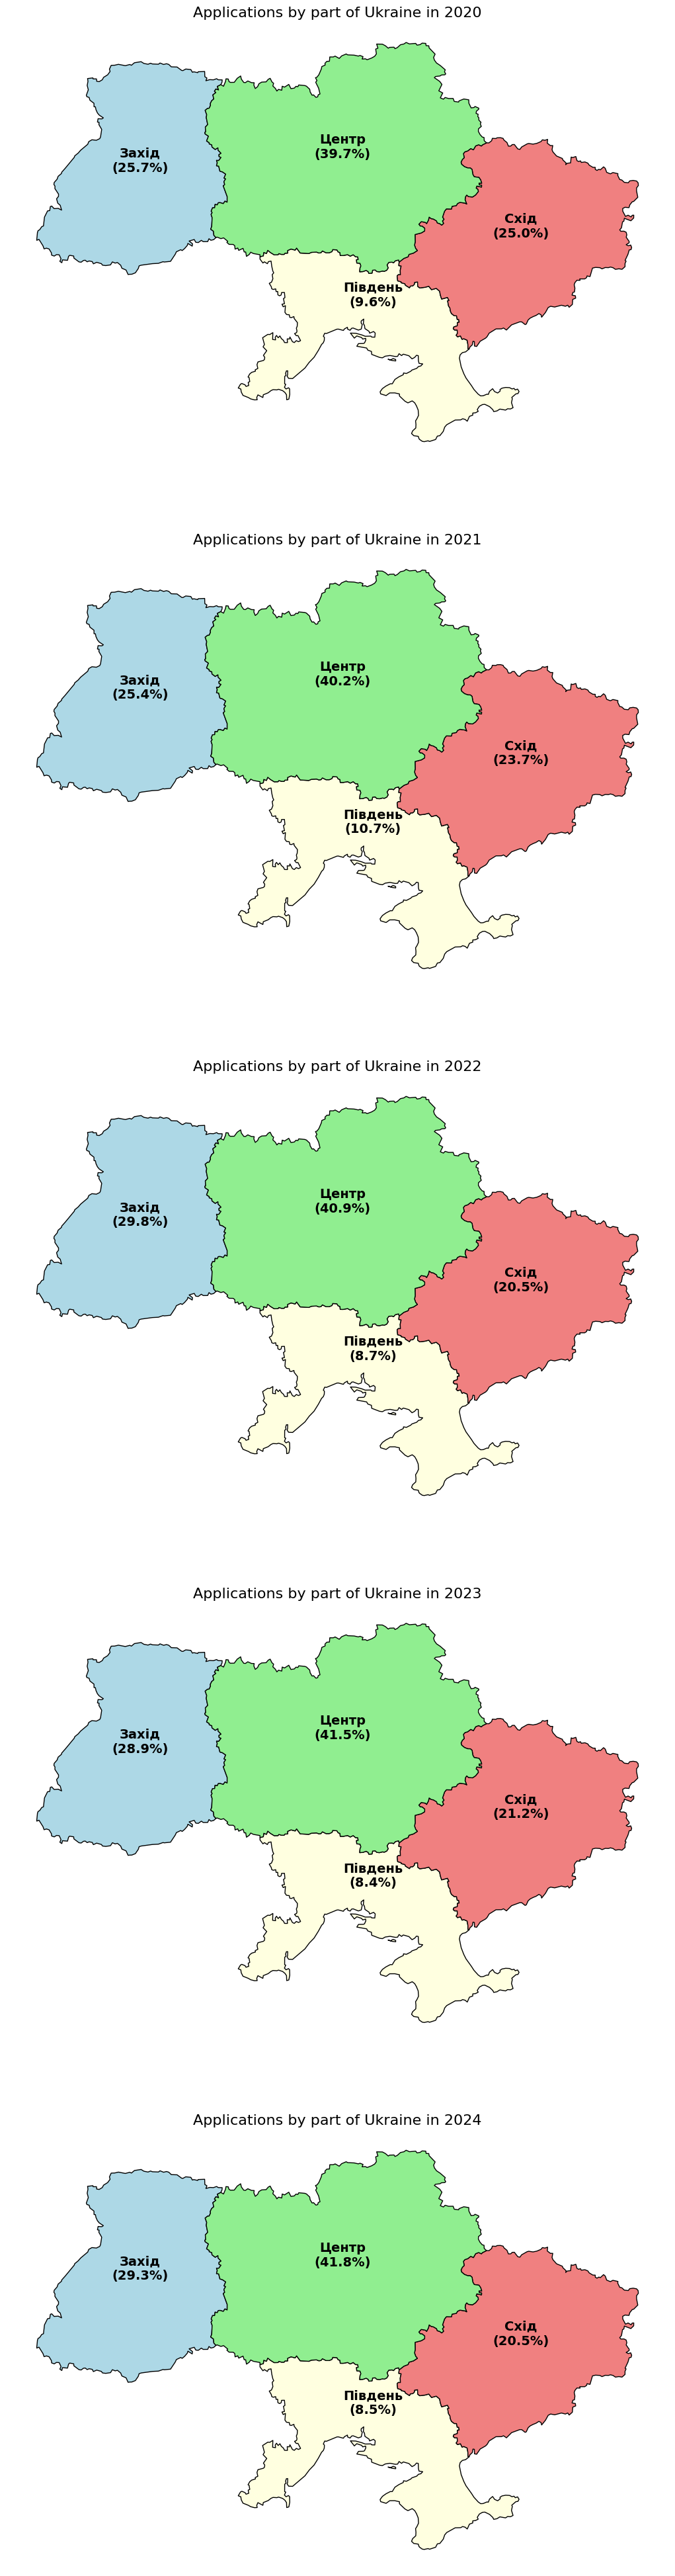

In [37]:
build_plots_distribution_appliacations_by_parts_of_ukraine(tender_offers, ukraine_map)

In [38]:
def build_maps_regions_relative_enrollment_koef(tender_offers: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    grouped_by_regions = tender_offers.groupby(['region_name', 'year']).agg(
        application_number_sum=('applications_number', 'sum'),
    ).reset_index()
    total_population = population_by_region['population'].sum()
    grouped_by_regions['ratio'] = grouped_by_regions.apply(
        lambda x: x['application_number_sum'] / population_by_region.loc[population_by_region['region'] == x['region_name'], 'population'].values[0] 
        if len(population_by_region.loc[population_by_region['region'] == x['region_name'], 'population'].values) > 0 else 0, 
        axis=1
    )
    unique_years = grouped_by_regions['year'].unique()
    region_ratios = grouped_by_regions.set_index(['region_name', 'year'])['ratio'].to_dict()
    avg_ratios = grouped_by_regions.groupby('year').agg(
        avg_ratio=('application_number_sum', lambda x: x.sum() / total_population)
    ).reset_index().set_index('year')['avg_ratio'].to_dict()
    fig, axes = plt.subplots(nrows=len(unique_years), ncols=1, figsize=(50, 50), sharex=True, sharey=True)
    for i, year in enumerate(unique_years):
        by_year = grouped_by_regions[grouped_by_regions['year'] == year]
        avg_ratio = avg_ratios[year]
        ukraine_map.plot(ax=axes[i], edgecolor='black')
        for idx, row in ukraine_map.iterrows():
            region_name = row['cyrillic_name']
            region_ratio = region_ratios.get((region_name, year), None)
            if region_ratio is not None:
                color = 'green' if region_ratio >= avg_ratio else 'red'
            else:
                color = 'gray'
            
            ukraine_map.loc[ukraine_map['cyrillic_name'] == region_name].plot(ax=axes[i], color=color, edgecolor='black')
            
            centroid = row['geometry'].centroid
            axes[i].text(centroid.x, centroid.y, region_name, fontsize=5, ha='center', color='black', weight='bold')
        axes[i].set_aspect(1.5)
        for spine in axes[i].spines.values():
            spine.set_visible(False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
        axes[i].set_title(f"Do more of their population enter the region than the average for Ukraine in {year}", fontsize=16)
    plt.show()


## 13) Map (green/red) by regions of Ukraine. Green represents regions where the number of enrollment applications divided by the region's population is higher than the national average.
The following consistently remain in the top: ["Київ", "Харківська облать", "Львівська область", "Тернопільська область", "Івано-Франківська область"]


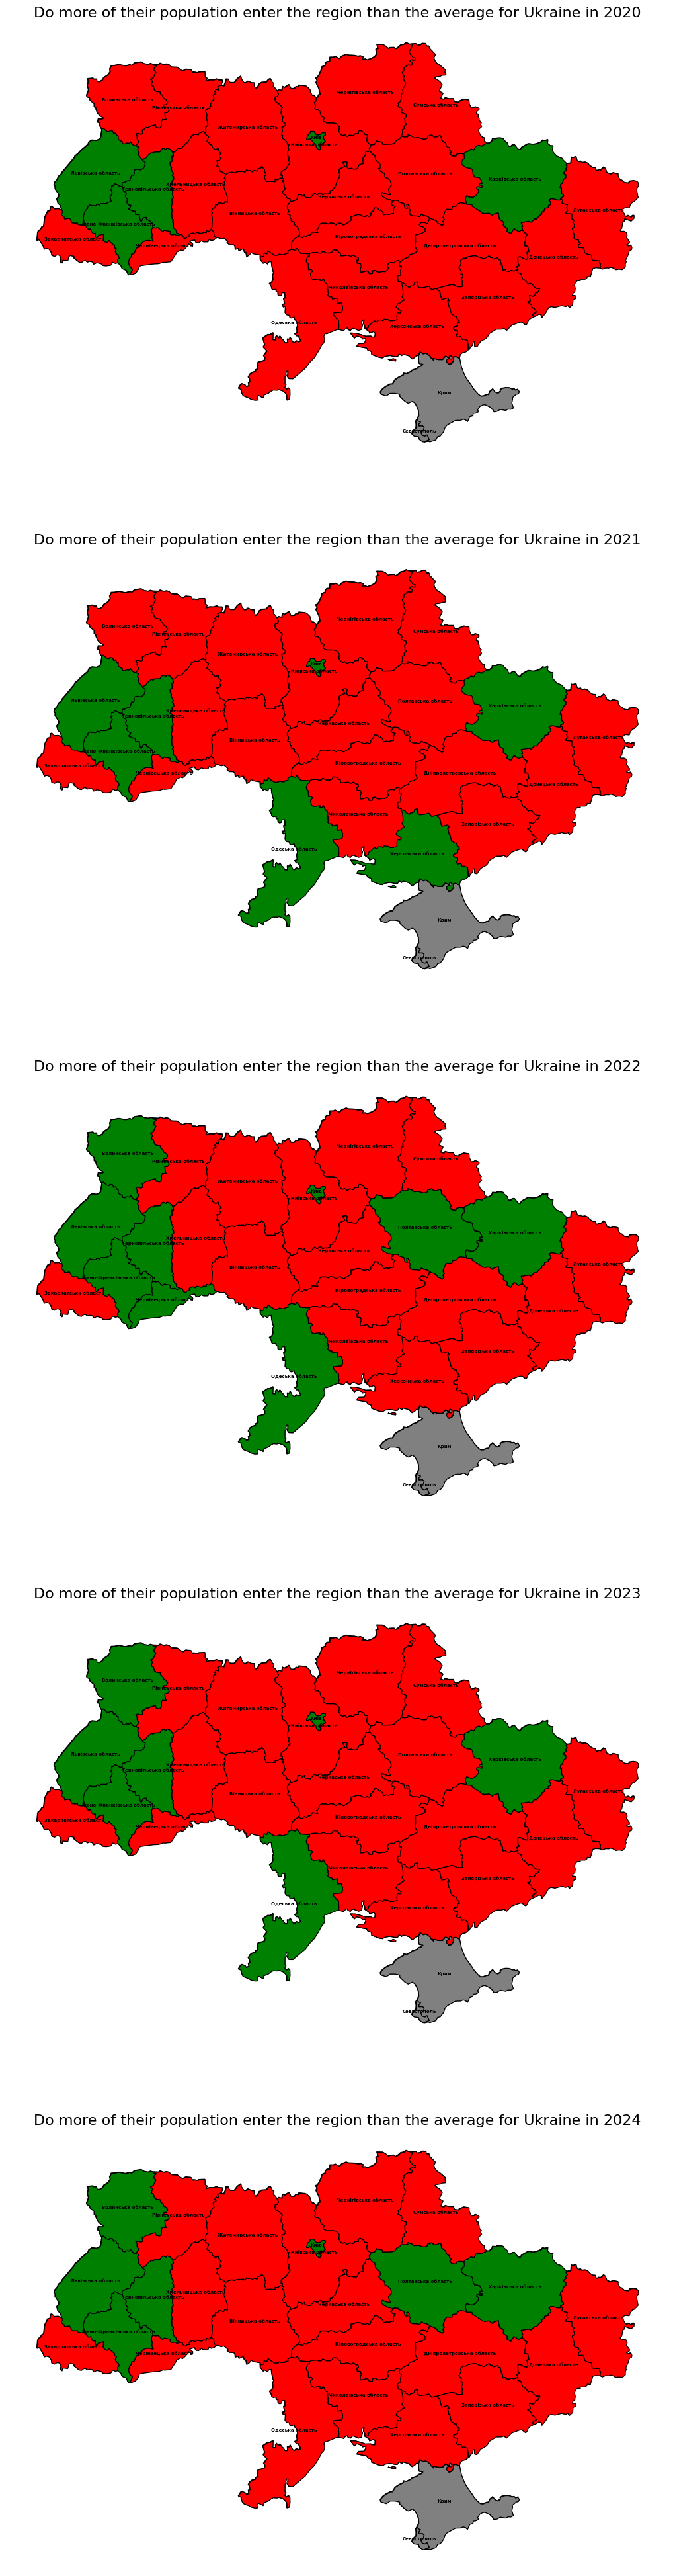

In [39]:
build_maps_regions_relative_enrollment_koef(tender_offers, ukraine_map)

In [40]:
def build_maps_regions_by_license_capacity(tender_offers: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    grouped_by_region_by_year = df.merge(regions_df, on="region_code", how="left")
    grouped_by_region_by_year = grouped_by_region_by_year[
        (df['unused_license_capacity'].notna()) & (df['license_capacity'].notna())
    ].groupby(['year', 'region_name']).agg(
        sum_license_capacity=('license_capacity', 'sum'),
        sum_unused_license_capacity=('unused_license_capacity', 'sum')
    ).reset_index()
    grouped_by_region_by_year['sum_used_license_capacity'] = (
        grouped_by_region_by_year['sum_license_capacity'] - 
        grouped_by_region_by_year['sum_unused_license_capacity']
    )
    grouped_by_region_by_year['percentage_of_used_capacity'] = (
        grouped_by_region_by_year['sum_used_license_capacity'] / 
        grouped_by_region_by_year['sum_license_capacity']
    )
    grouped_by_region_by_year.sort_values(by='sum_used_license_capacity', ascending=False)
    unique_years = grouped_by_region_by_year['year'].unique()
    fig, axes = plt.subplots(len(unique_years), 1, figsize=(15, 8 * len(unique_years)), sharex=False)
    for i, year in enumerate(unique_years):
        by_year = grouped_by_region_by_year[grouped_by_region_by_year['year'] == year]
        ukraine_map_by_year = ukraine_map.merge(by_year, left_on="cyrillic_name", right_on="region_name", how="left")
        ukraine_map_by_year.plot(column='percentage_of_used_capacity', cmap='RdYlBu', legend=True,  edgecolor='black',
                 legend_kwds={'label': "Percentage", 'orientation': "vertical"}, 
                 ax=axes[i])
        no_value = ukraine_map_by_year[ukraine_map_by_year['percentage_of_used_capacity'].isna()]
        ukraine_map_by_year_with_value = ukraine_map_by_year[ukraine_map_by_year['percentage_of_used_capacity'].notna()]
        no_value.plot(color='lightgrey', edgecolor='black', ax=axes[i])
        for idx, row in ukraine_map_by_year_with_value.iterrows():
            x, y = adjust_coordinates(row.geometry.centroid.x, row.geometry.centroid.y, row)
            axes[i].annotate(text=f"{round(row['percentage_of_used_capacity'] * 100, 2)}%", xy=(x, y), 
                         horizontalalignment='center', fontsize=9, color='black')
        axes[i].set_title(f'Year {year}: Percentage of used licensy capacity')
        axes[i].set_aspect(1.5)
        for spine in axes[i].spines.values():
            spine.set_visible(False)
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    plt.tight_layout()
    plt.show()

## 14) Regions by used licensy capacity percentage
During 2020 and 2021, the percentage of the used license volume was quite different throughout Ukraine, but the percentage was clearly the largest in the western regions. And in 2022, it can be divided into two parts (Western and Central / Eastern and Southern)

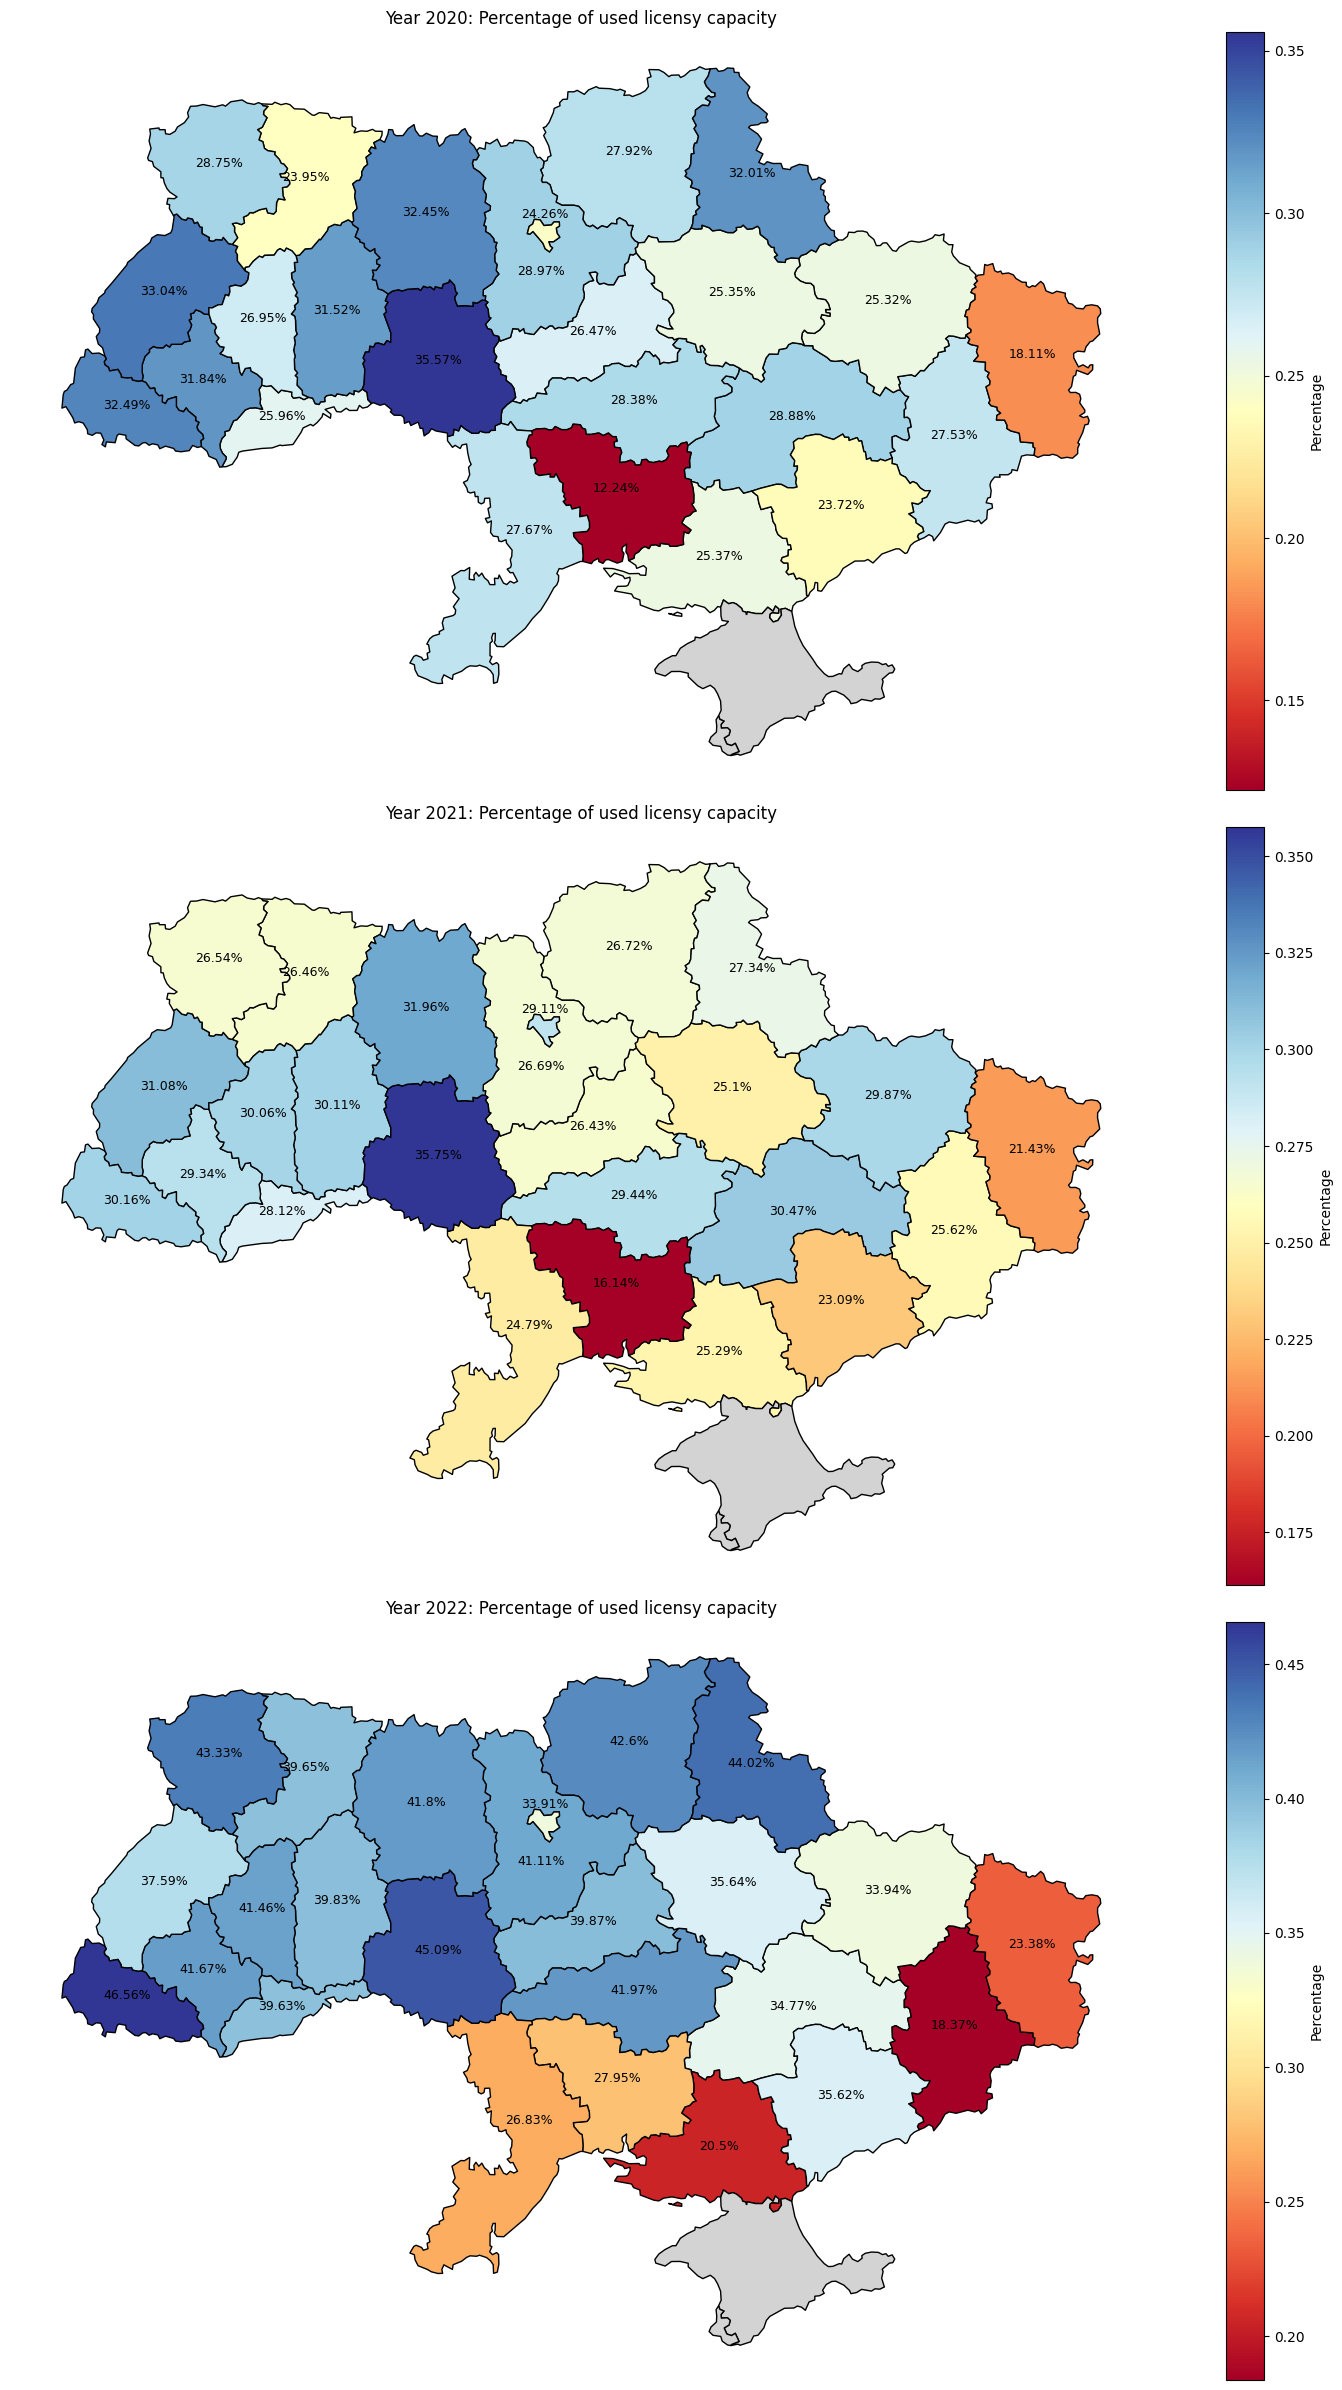

In [41]:
build_maps_regions_by_license_capacity(tender_offers, ukraine_map)

In [42]:
def build_plot_correlation_between_capacity_and_competition(df: pd.DataFrame) -> None:
    filtered_data = df[['license_capacity', 'competition_budget']].dropna()
    filtered_data['competition_budget_log'] = np.log1p(filtered_data['competition_budget'])
    filtered_data['license_capacity_log'] = np.log1p(filtered_data['license_capacity'])
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='license_capacity_log', y='competition_budget_log', data=filtered_data, alpha=0.7)
    
    x_ticks = np.log1p(np.geomspace(df['license_capacity'].min() + 1, df['license_capacity'].max(), num=5))
    y_ticks = np.log1p(np.geomspace(df['competition_budget'].min() + 1, df['competition_budget'].max(), num=5))
    plt.xticks(x_ticks, np.expm1(x_ticks).astype(int))
    plt.yticks(y_ticks, np.expm1(y_ticks).astype(int))
    plt.title('Competition level vs license capacity', fontsize=16)
    plt.xlabel('License capacity', fontsize=14)
    plt.ylabel('Number of applications for one license place', fontsize=14)
    plt.grid(True)
    plt.show()

## 15) Correlation between license capacity and level of competition
For convenience, I converted the values ​​to a logarithmic scale. As can be seen from the graph, there is no correlation

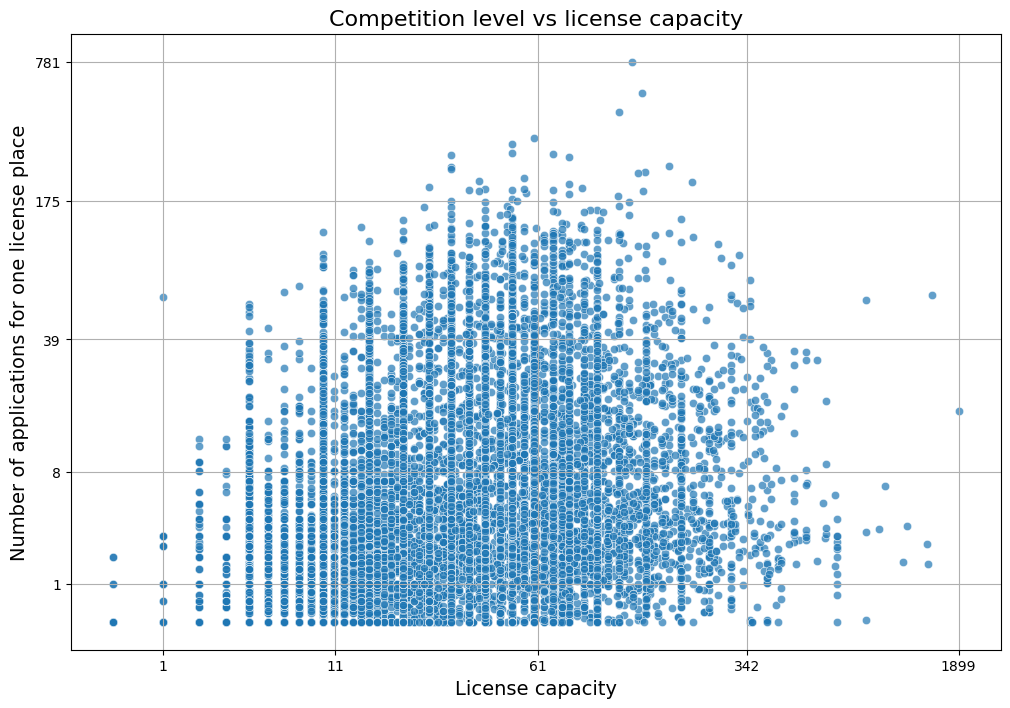

In [43]:
build_plot_correlation_between_capacity_and_competition(df)

In [44]:
def build_plot_correlation_between_competition_and_avg_score(df: pd.DataFrame) -> None:
    filtered_data = df[['competition_budget', 'avg_score_budget']].dropna()
    filtered_data['competition_budget_log'] = np.log1p(filtered_data['competition_budget'])
    filtered_data = filtered_data[filtered_data['avg_score_budget'] >= 100]
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x='avg_score_budget', 
        y='competition_budget_log', 
        data=filtered_data, 
        alpha=0.7
    )
    y_ticks = np.log1p(np.geomspace(df['competition_budget'].min() + 1, df['competition_budget'].max(), num=5))
    plt.yticks(y_ticks, np.expm1(y_ticks).astype(int))
    plt.title('Average Budget Score vs Competition Level', fontsize=16)
    plt.xlabel('Average Budget Score', fontsize=14)
    plt.ylabel('Competition Level (log scale)', fontsize=14)
    plt.grid(True)
    plt.show()

## 16) Correlation between the license capacity and the average entrance score of those admitted
You can see a small trend of increasing competition as the score increases

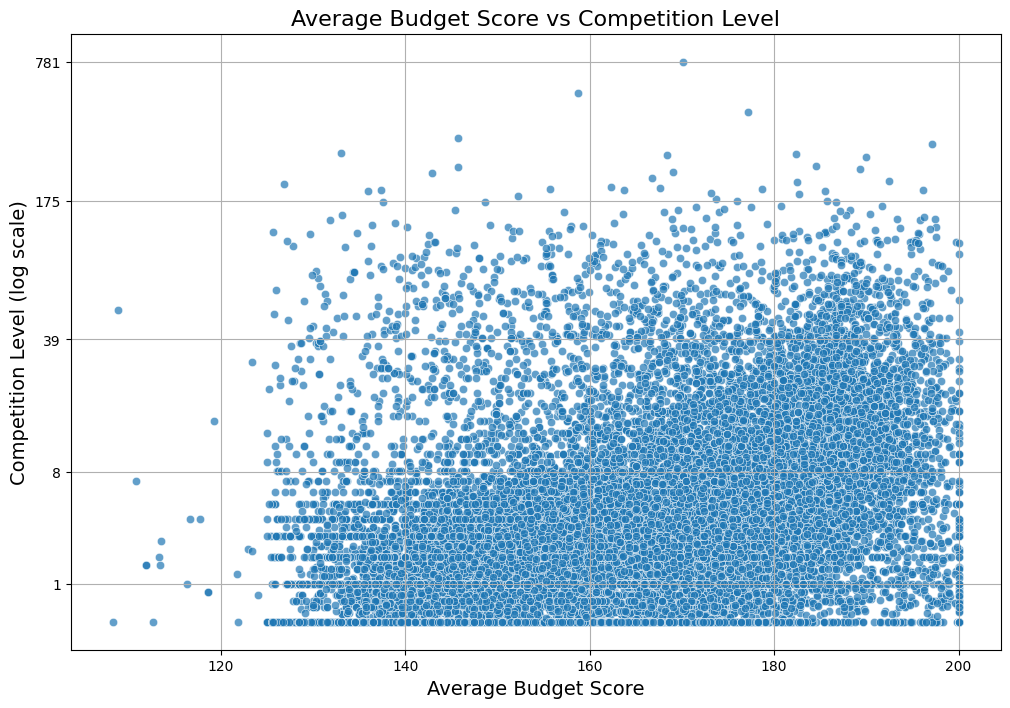

In [45]:
build_plot_correlation_between_competition_and_avg_score(df)

In [46]:
def build_map_most_popular_area_in_region(tender_offers: pd.DataFrame, ukraine_map: gpd.GeoDataFrame) -> None:
    ind_dict = {
        'Електроніка, автоматизація та електронні комунікації': True,
        'Виробництво та технології': True,
        'Автоматизація та приладобудування': True,
        'Механічна інженерія': True,
        'Електрична інженерія': True,
        'Електроніка та телекомунікації': True,
    }
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    popular_fields = (
        tender_offers.groupby(['region_name', 'area'])['applications_number']
            .sum()
            .reset_index()
            .sort_values(['region_name', 'applications_number'], ascending=[True, False])
            .drop_duplicates('region_name')
    )
    popular_fields = popular_fields[['region_name', 'area']]
    fields = popular_fields['area'].unique()
    popular_fields['is_industrial'] = popular_fields['area'].apply(lambda x: ind_dict.get(x, False))
    
    industrial_fields_list = popular_fields[popular_fields['is_industrial']==True]
    non_industrial_fields_list = popular_fields[popular_fields['is_industrial']==False]
    
    industrial_colors = plt.get_cmap('Reds', len(industrial_fields_list))
    non_industrial_colors = plt.get_cmap('Greens', len(non_industrial_fields_list))
    industrial_mapping = {field: industrial_colors(i) for i, field in enumerate(industrial_fields_list['area'])}
    non_industrial_mapping = {field: non_industrial_colors(i) for i, field in enumerate(non_industrial_fields_list['area'])}
    popular_fields['color'] = popular_fields['area'].map({**industrial_mapping, **non_industrial_mapping})

    
    ukraine_map = ukraine_map.merge(popular_fields, left_on='cyrillic_name', right_on='region_name', how='left')
    no_value = ukraine_map[ukraine_map['area'].isna()]
    ukraine_map_with_value = ukraine_map[ukraine_map['area'].notna()]
    no_value.plot(color='lightgrey', edgecolor='black', ax=ax)

    
    ukraine_map_with_value.plot(ax=ax, color=ukraine_map_with_value['color'], edgecolor='black')

    for idx, row in ukraine_map_with_value.iterrows():
            x, y = adjust_coordinates(row.geometry.centroid.x, row.geometry.centroid.y, row)
            is_prom = "Пром." if ind_dict.get(row['area']) else "Не пром."
            ax.annotate(text=f"{is_prom}", xy=(x, y), 
                         horizontalalignment='center', fontsize=9, color='black')
    
    ax.set_aspect(1.5)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    for field, color in {**industrial_mapping, **non_industrial_mapping}.items():
        plt.scatter([], [], color=color, label=field)
    plt.legend(title="Popular Fields", loc='lower left')
    
    plt.title('Most Popular Knowledge Field by Region')
    plt.show()

## 17) Most popular knowledge fields by region
In the south and east of Ukraine, 5 oblasts are industrial, this is more than in the rest of Ukraine combined

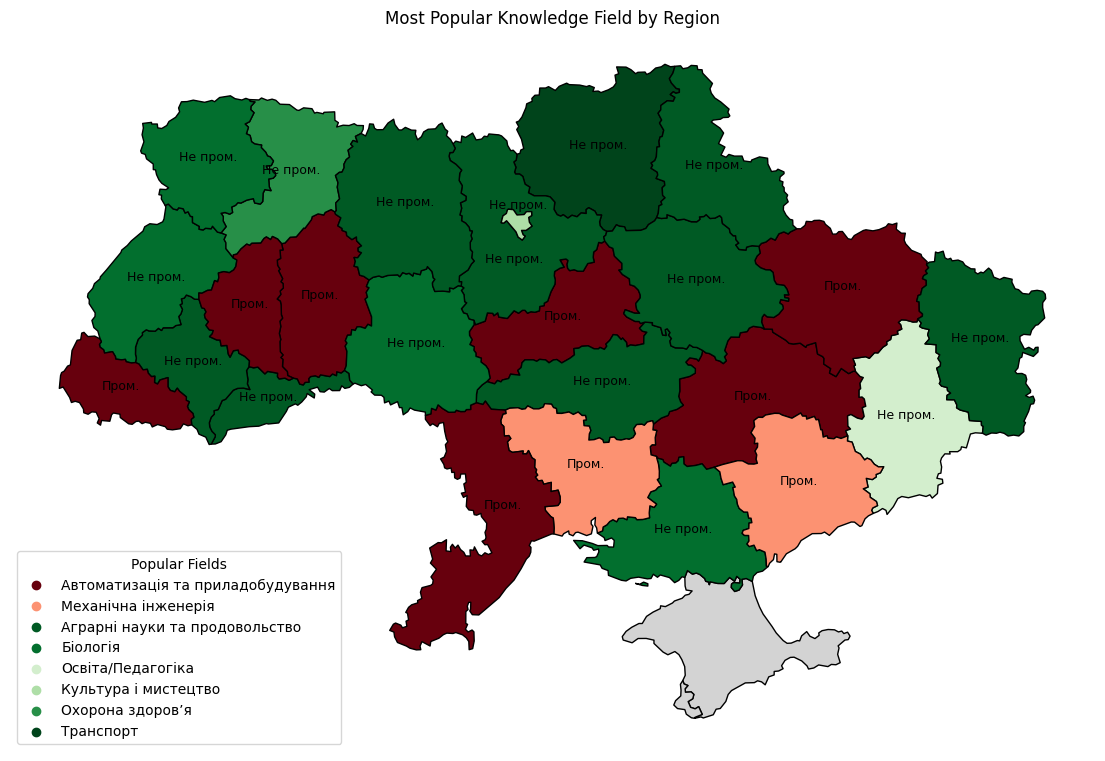

In [47]:
build_map_most_popular_area_in_region(tender_offers, ukraine_map)

---

# Conclusion

As a result of this work, an analysis of the competitive proposals for admission to Ukrainian universities was carried out. Differences between regions of Ukraine were highlighted, including average scores, priorities, the percentage of licensed capacity used, the ratio of applications in different parts of Ukraine, the population-to-admissions ratio, and sectoral orientation. 

Specialties with the highest entrance scores, the most popular universities and specialties, and knowledge areas were determined. The distribution of scores among applicants, regional distribution, forms of study (budget vs contract), and educational levels were also analyzed, revealing certain correlations.

This will help explore the issues in Ukrainian education, uncover interesting patterns, and provide a deeper understanding of the current state of education in Ukraine.
